In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import matplotlib as mpl
import matplotlib.font_manager as fm

### 한글 폰트 설정

In [3]:
# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'  # 사용할 폰트 설정

# 기본적인 폰트 설정(옵션)
plt.rcParams['font.size'] = 12            # 기본 폰트 크기
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

# A. 전국관광지정보표준데이터 (공공데이터포털)

In [4]:
# "전국관광지정보표준데이터.csv" 불러오기

whole_tour = pd.read_csv("전국관광지정보표준데이터.csv", encoding = 'cp949')
whole_tour.head(1)

,관광지명,관광지구분,소재지도로명주소,소재지지번주소,위도,경도,면적,공공편익시설정보,숙박시설정보,운동및오락시설정보,...,지원시설정보,지정일자,수용인원수,주차가능수,관광지소개,관리기관전화번호,관리기관명,데이터기준일자,제공기관코드,제공기관명
0,무각사,관광지,광주광역시 서구 운천로 230,NaN,35.153781,126.856018,510.0,화장실+주차장,NaN,NaN,...,NaN,2007-07-27,100,30,"일주문, 사천왕문, 대웅전, 종각 등 전통사찰의 형태를 여법하게 갖추며 일주문에서 ...",062-383-0108,광주광역시 서구청,2022-01-01,6290000,광주광역시


## (0) 데이터 전처리

### (0-1) 해당 데이터셋에 '세종'이 없음을 확인

In [7]:
# '소재지도로명주소' 컬럼에 '세종' 키워드가 있는지 확인
contains_세종_도로명주소 = whole_tour['소재지도로명주소'].str.contains('세종')

# '소재지지번주소' 컬럼에 '세종' 키워드가 있는지 확인
contains_세종_지번주소 = whole_tour['소재지지번주소'].str.contains('세종')

# '소재지도로명주소' 또는 '소재지지번주소' 컬럼 중 하나라도 '세종' 키워드가 들어간 행 선택
result = whole_tour[contains_세종_도로명주소 | contains_세종_지번주소]

# '결과 확인
print(result[['소재지도로명주소', '소재지지번주소']])

Empty DataFrame
Columns: [소재지도로명주소, 소재지지번주소]
Index: []


### (0-2) 필요 없는 컬럼 삭제하기

In [8]:
whole_tour = whole_tour.drop(columns = ['관광지구분','면적','지정일자','관리기관전화번호','관리기관명','제공기관코드','제공기관명','데이터기준일자'], axis=1)
whole_tour.head(2)

,관광지명,소재지도로명주소,소재지지번주소,위도,경도,공공편익시설정보,숙박시설정보,운동및오락시설정보,휴양및문화시설정보,접객시설정보,지원시설정보,수용인원수,주차가능수,관광지소개
0,무각사,광주광역시 서구 운천로 230,NaN,35.153781,126.856018,화장실+주차장,NaN,NaN,NaN,NaN,NaN,100,30,"일주문, 사천왕문, 대웅전, 종각 등 전통사찰의 형태를 여법하게 갖추며 일주문에서 ..."
1,창작농성골,광주광역시 서구 월산로173번길 15-1,NaN,35.152973,126.892914,주차장,NaN,NaN,NaN,NaN,NaN,100,20,"골목마다 벽화를 비롯해 쉼터와 벚나무, 동백나무 등의 묘목이 식재을 띤 명소"


### (0-3) '시도명' & '시군구명' 컬럼으로 변환

In [9]:
# '소재지도로명주소'or'소재지지번주소' 중 하나라도 값이 있으면, 해당 값을 '시도명'과 '시군구명'으로 설정
whole_tour['시도명'] = whole_tour['소재지도로명주소'].str.split(' ', n=1).str[0].fillna(whole_tour['소재지지번주소'].str.split(' ', n=1).str[0])
whole_tour['시군구명'] = whole_tour['소재지도로명주소'].str.split(' ', n=2).str[1].fillna(whole_tour['소재지지번주소'].str.split(' ', n=2).str[1])

# 기존의 '소재지도로명주소'와 '소재지지번주소' 컬럼은 삭제
whole_tour.drop(['소재지도로명주소', '소재지지번주소'], axis=1, inplace=True)

# '시도명'과 '시군구명' 컬럼을 가장 앞쪽 열로 위치
whole_tour.insert(0, '시군구명', whole_tour.pop('시군구명'))
whole_tour.insert(0, '시도명', whole_tour.pop('시도명'))

### (0-4) '시도명' 값 정리하기

In [10]:
whole_tour['시도명'].unique()

array(['광주광역시', '서울특별시', '경상북도', '전라남도', '대전광역시', '강원도', '경기도', '부산광역시',
       '전라북도', '제주특별자치도', '울산광역시', '경남', '경상남도', '충청북도', '대구광역시', '인천광역시',
       '전남', '충청남도', '안성시', '강원특별자치도', '경기도연천군전곡읍선사로76',
       '경기도연천군전곡읍양연로1510'], dtype=object)

#### ① '시도명' 중 동일한 지역 일치시키기

In [11]:
whole_tour['시도명'].replace({
    '강원도': '강원특별자치도',
    '전남': '전라남도',
    '경남': '경상남도'
}, inplace=True)

#### ② '경기도 연천군' 정리하기

In [12]:
whole_tour.loc[whole_tour['시도명'].str.contains('경기도'), '시도명'] = '경기도'
whole_tour.loc[whole_tour['시도명'].str.contains('연천군'), '시군구명'] = '연천군'

#### ③ '경기도 안성시' 정리하기

In [13]:
whole_tour.loc[whole_tour['시도명'].str.contains('안성시', na=False), '시도명'] = '경기도'
whole_tour.loc[whole_tour['시도명'].str.contains('안성시', na=False), '시군구명'] = '안성시'

In [14]:
whole_tour['시도명'].unique()  # '세종' 없어서 총 16개

array(['광주광역시', '서울특별시', '경상북도', '전라남도', '대전광역시', '강원특별자치도', '경기도',
       '부산광역시', '전라북도', '제주특별자치도', '울산광역시', '경상남도', '충청북도', '대구광역시',
       '인천광역시', '충청남도'], dtype=object)

### ※ 데이터 전처리 후 확인

In [15]:
whole_tour.tail(2)

,시도명,시군구명,관광지명,위도,경도,공공편익시설정보,숙박시설정보,운동및오락시설정보,휴양및문화시설정보,접객시설정보,지원시설정보,수용인원수,주차가능수,관광지소개
858,강원특별자치도,태백시,태백고생대자연사박물관,37.094899,129.039632,주차장+도로+공중화장실+다목적공원+자연사박물관,NaN,NaN,NaN,NaN,NaN,500,50,고생대 자연환경과 그 곳에 살았던 생물역사를 추적할 수 있는 다양한 화석 및 퇴적구...
859,강원특별자치도,원주시,간현관광지,37.364893,127.832544,관리사무소+주차장+화장실+샤워장,민박+모텔,풋살장+족구장,야영장+공연장+수련원,NaN,NaN,50000,268,섬강과 삼산천 강물이 합수되는 지점에 위치하고 있어 빼어난 자연경관과 소금산 등반 ...


## (1) '공공편익시설정보' 컬럼

In [16]:
# '공공편익시설정보' 컬럼 확인하기

# whole_tour['공공편익시설정보'].unique()

In [17]:
# '공공편익시설정보' 컬럼에 있는 모든 키워드 확인

whole_tour['공공편익시설정보'].str.split('+').explode().str.strip().unique()

array(['화장실', '주차장', '승강기', '물품보관함', '수유실', '쉼터', '산천동마을마당(작은쉼터)',
       '관광안내소', '공원', '기념관', '의무실', '식당', '초보고객안내실', '종합안내소', '없음',
       '운동시설', '지하주차장', '비지터센터', '화장실(3동)', '매표소', 'Y', '도로주차장관리사무소',
       '화장실 등', '월곶면사무소', '화장실, 주차장', '광장', '보행자도로 등', '공중화장실', '관리사무소',
       '전망대', '정수장', '도로', '정자', '메타세쿼이아길 L=2.1km', '어린이프로방스', '영화세트장',
       '개구리생태공원', '에코허브센터', '호남기후변화체험관', '매표소 3개소', '검표소 6개소', '쉼터 2개소',
       '화장실 4개소', '관리사무소(매표소)', '한옥형 본관', '고고역사관', '민속관', '전시실', '어린이체험실',
       '매점', '화장실(4동)', '샤워장', '뻘배체험장', '취사장', '민속놀이체험장', '숲체험교실',
       '4D입체영상관. 천체투영실 천체관측실 전시실', '샤워실', '급수대', '휠체어', '유모차대여소', '보관소',
       '고객지원센터', '야외놀이터', '화장실(1동)', '샤워탈의장', '배수지', '변전소', '관광정보안내소',
       '오수처리장', '정배수장', '순환도로', '전용상수도', '정수장(배수지)', '이벤트광장', '배수지오수처리장',
       '작은 도서관', '안내데스크', '클럽하우스', '락카룸', '사우나', '골프장', 'ATM', '테마체험관',
       '', '체험관 1', '숙박동 1', '휴게시설 1', '화장실 1', '안내소', '생태체험관', '사무실 전시실',
       '상시관찰원', '사육동', '관찰로', '어린이놀이시설', '파고라 등', '벤치', '벚꽃길', '데크로드',

### (1-0) 요소들 선정 (by 언급 많이 되는 키워드 기준)

In [18]:
from wordcloud import WordCloud
from wordcloud import ImageColorGenerator

In [19]:
keywords = whole_tour['공공편익시설정보'].str.split('+').explode().str.strip()

In [20]:
# 많이 언급되는 키워드를 수치로 확인하기
keywords.value_counts(sort=True, ascending=False)

공공편익시설정보
화장실         508
주차장         454
관리사무소       124
관광안내소        59
도로           58
           ... 
유모차대여         1
공예·특산품관       1
순천만쉼터         1
물레방아광장 등      1
상하수도 시설       1
Name: count, Length: 457, dtype: int64

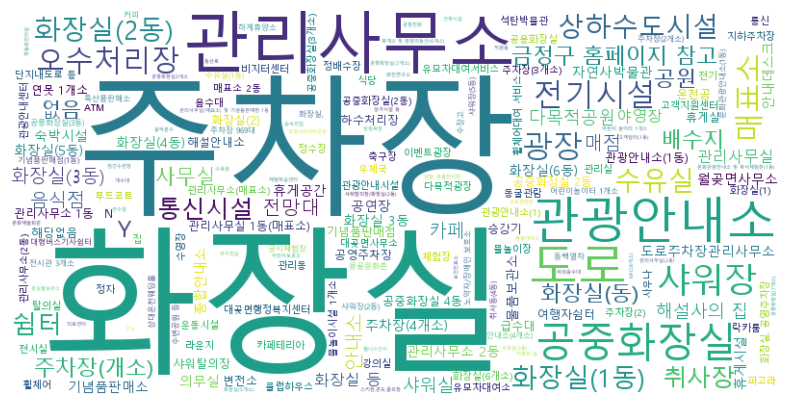

In [21]:
# 폰트 경로 설정
font_path = r'C:/Windows/Fonts/malgun.ttf'

# 키워드 빈도수 계산
keyword_counts = keywords.value_counts()

# 워드클라우드 생성
wordcloud = WordCloud(font_path=font_path, width=800, height=400, background_color='white').generate_from_frequencies(keyword_counts)

# 시각화
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## ※ 요소들 선정 (10개)
### → '화장실', '주차장', '관리사무소', '안내소',  '샤워장', '광장', '수유실', '휴게/쉼터', '공원', '카페/커피'
- c.f.) 도로, 배수시설 등 관광지와 상관없는 일반적인 요소들은 제외

### (1-1) '화장실' 컬럼 추가

In [22]:
# '공공편익시설정보' 컬럼 안에 '화장실'이라는 키워드 포함 여부
def has_toilet(info):
    return 1 if '화장실' in info else 0

# '화장실' 컬럼 추가하여 기본값 0으로 설정
whole_tour.insert(6, '화장실', 0)

# '공공편익시설정보' 컬럼을 기반으로 '화장실' 컬럼의 값 입력
whole_tour['화장실'] = whole_tour['공공편익시설정보'].apply(has_toilet)

### (1-2) '주차장' 컬럼 추가

In [23]:
# '공공편익시설정보' 컬럼 안에 '주차장'이라는 키워드 포함 여부
def has_parking(info):
    return 1 if '주차장' in info else 0

# '주차장' 컬럼 추가하여 기본값 0으로 설정
whole_tour.insert(7, '주차장', 0)

# '공공편익시설정보' 컬럼을 기반으로 '주차장' 컬럼의 값 입력
whole_tour['주차장'] = whole_tour['공공편익시설정보'].apply(has_parking)

### (1-3) '관리사무소' 컬럼 추가

In [24]:
# '공공편익시설정보' 컬럼 안에 '관리'or'사무'이라는 키워드 포함 여부
def has_office(info):
    return 1 if ('관리' in info) or ('사무' in info) else 0

# '관리사무소' 컬럼 추가하여 기본값 0으로 설정
whole_tour.insert(8, '관리사무소', 0)

# '공공편익시설정보' 컬럼을 기반으로 '관리사무소' 컬럼의 값 입력
whole_tour['관리사무소'] = whole_tour['공공편익시설정보'].apply(has_office)

### (1-4) '안내소' 컬럼 추가

In [25]:
# '공공편익시설정보' 컬럼 안에 '안내'이라는 키워드 포함 여부
def has_guide(info):
    return 1 if '안내' in info else 0

# '안내소' 컬럼 추가하여 기본값 0으로 설정
whole_tour.insert(9, '안내소', 0)

# '공공편익시설정보' 컬럼을 기반으로 '안내소' 컬럼의 값 입력
whole_tour['안내소'] = whole_tour['공공편익시설정보'].apply(has_guide)

### (1-5) '샤워장' 컬럼 추가

In [26]:
# '공공편익시설정보' 컬럼 안에 '샤워장'이라는 키워드 포함 여부
def has_shower(info):
    return 1 if '샤워장' in info else 0

# '샤워장' 컬럼 추가하여 기본값 0으로 설정
whole_tour.insert(10, '샤워장', 0)

# '공공편익시설정보' 컬럼을 기반으로 '샤워장' 컬럼의 값 입력
whole_tour['샤워장'] = whole_tour['공공편익시설정보'].apply(has_shower)

### (1-6) '광장' 컬럼 추가

In [27]:
# '공공편익시설정보' 컬럼 안에 '광장'이라는 키워드 포함 여부
def has_plaza(info):
    return 1 if '광장' in info else 0

# '광장' 컬럼 추가하여 기본값 0으로 설정
whole_tour.insert(11, '광장', 0)

# '공공편익시설정보' 컬럼을 기반으로 '광장' 컬럼의 값 입력
whole_tour['광장'] = whole_tour['공공편익시설정보'].apply(has_plaza)

### (1-7) '수유실' 컬럼 추가

In [28]:
# '공공편익시설정보' 컬럼 안에 '수유실'이라는 키워드 포함 여부
def has_feeding(info):
    return 1 if '수유실' in info else 0

# '수유실' 컬럼 추가하여 기본값 0으로 설정
whole_tour.insert(12, '수유실', 0)

# '공공편익시설정보' 컬럼을 기반으로 '수유실' 컬럼의 값 입력
whole_tour['수유실'] = whole_tour['공공편익시설정보'].apply(has_feeding)

### (1-8) '휴게/쉼터' 컬럼 추가

In [29]:
# '공공편익시설정보' 컬럼 안에 '휴게'or'쉼터'라는 키워드 포함 여부
def has_rest(info):
    return 1 if ('휴게' in info) or ('쉼터' in info) else 0

# '휴게/쉼터' 컬럼 추가하여 기본값 0으로 설정
whole_tour.insert(13, '휴게/쉼터', 0)

# '공공편익시설정보' 컬럼을 기반으로 '휴게/쉼터' 컬럼의 값 입력
whole_tour['휴게/쉼터'] = whole_tour['공공편익시설정보'].apply(has_rest)

### (1-9) '공원' 컬럼 추가

In [30]:
# '공공편익시설정보' 컬럼 안에 '공원'이라는 키워드 포함 여부
def has_park(info):
    return 1 if '공원' in info else 0

# '공원' 컬럼 추가하여 기본값 0으로 설정
whole_tour.insert(14, '공원', 0)

# '공공편익시설정보' 컬럼을 기반으로 '공원' 컬럼의 값 입력
whole_tour['공원'] = whole_tour['공공편익시설정보'].apply(has_park)

### (1-10) '카페/커피' 컬럼 추가

In [31]:
# '공공편익시설정보' 컬럼 안에 '카페'or'커피'이라는 키워드 포함 여부
def has_coffee(info):
    return 1 if ('카페' in info) or ('커피' in info) else 0

# '카페/커피' 컬럼 추가하여 기본값 0으로 설정
whole_tour.insert(15, '카페/커피', 0)

# '공공편익시설정보' 컬럼을 기반으로 '카페/커피' 컬럼의 값 입력
whole_tour['카페/커피'] = whole_tour['공공편익시설정보'].apply(has_coffee)

### ※ 추가한 컬럼들 확인

In [32]:
whole_tour.iloc[:, 6:16].tail()

,화장실,주차장,관리사무소,안내소,샤워장,광장,수유실,휴게/쉼터,공원,카페/커피
855,1,1,0,0,0,0,0,0,0,0
856,1,1,0,0,0,0,0,0,0,0
857,1,1,0,0,0,0,0,0,1,0
858,1,1,0,0,0,0,0,0,1,0
859,1,1,1,0,1,0,0,0,0,0


## (2) '숙박시설정보' 컬럼

In [33]:
# '숙박시설정보' 컬럼 확인하기
# whole_tour['숙박시설정보'].unique()

In [34]:
# '숙박시설정보' 컬럼을 유무 값으로 대체
whole_tour['숙박시설정보'] = whole_tour['숙박시설정보'].notnull().astype(int)  # 무엇이라도 있으면 1, 없으면 0

## (3) '운동및오락시설정보' 컬럼

In [35]:
# '운동및오락시설정보' 컬럼 확인하기
# whole_tour['운동및오락시설정보'].unique()

In [36]:
# '운동및오락시설정보' 컬럼을 유무 값으로 대체
whole_tour['운동및오락시설정보'] = whole_tour['운동및오락시설정보'].notnull().astype(int)  # 무엇이라도 있으면 1, 없으면 0

## (4) '휴양및문화시설정보' 컬럼

In [37]:
# '휴양및문화시설정보' 컬럼 확인하기
# whole_tour['휴양및문화시설정보'].unique()

In [38]:
# '휴양및문화시설정보' 컬럼을 유무 값으로 대체
whole_tour['휴양및문화시설정보'] = whole_tour['휴양및문화시설정보'].notnull().astype(int)  # 무엇이라도 있으면 1, 없으면 0

## (5) '접객시설정보' 컬럼

In [39]:
# '접객시설정보' 컬럼 확인하기
# whole_tour['접객시설정보'].unique()

In [40]:
# '접객시설정보' 컬럼을 유무 값으로 대체
whole_tour['접객시설정보'] = whole_tour['접객시설정보'].notnull().astype(int)  # 무엇이라도 있으면 1, 없으면 0

## (6) '지원시설정보' 컬럼

In [41]:
# '지원시설정보' 컬럼 확인하기
# whole_tour['지원시설정보'].unique()

In [42]:
# '지원시설정보' 컬럼을 유무 값으로 대체
whole_tour['지원시설정보'] = whole_tour['지원시설정보'].notnull().astype(int)  # 무엇이라도 있으면 1, 없으면 0

### ※ 최종 확인

In [43]:
whole_tour  # 860 rows × 24 columns
            # 다양한 요소들 컬럼 → 총 15개

,시도명,시군구명,관광지명,위도,경도,공공편익시설정보,화장실,주차장,관리사무소,안내소,...,공원,카페/커피,숙박시설정보,운동및오락시설정보,휴양및문화시설정보,접객시설정보,지원시설정보,수용인원수,주차가능수,관광지소개
0,광주광역시,서구,무각사,35.153781,126.856018,화장실+주차장,1,1,0,0,...,0,0,0,0,0,0,0,100,30,"일주문, 사천왕문, 대웅전, 종각 등 전통사찰의 형태를 여법하게 갖추며 일주문에서 ..."
1,광주광역시,서구,창작농성골,35.152973,126.892914,주차장,0,1,0,0,...,0,0,0,0,0,0,0,100,20,"골목마다 벽화를 비롯해 쉼터와 벚나무, 동백나무 등의 묘목이 식재을 띤 명소"
2,광주광역시,서구,유적근린공원,35.168799,126.871443,화장실,1,0,0,0,...,0,0,0,0,0,0,0,500,0,기원후 5세기 후반의 백제 역사를 간직하고 있음
3,광주광역시,서구,청춘발산마을,35.159180,126.891994,화장실,1,0,0,0,...,0,0,0,0,0,0,0,500,0,알록달록한 동네 한 바퀴를 돌아보며 즐기는 문화
4,광주광역시,서구,화담사,35.153530,126.878426,화장실+주차장,1,1,0,0,...,0,0,0,0,0,0,0,100,35,"옛부터 꽃이 많다고(군분)하여 화담이라 불렸으며, 계단으로 내려가는 중간에 동재와 ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
855,강원특별자치도,태백시,용연동굴,37.208883,128.941860,주차장+도로+공중화장실+동굴관람,1,1,0,0,...,0,0,0,0,0,0,0,500,100,「용연동굴」이란 이름은 용의 연못 속에 있던 용이 계곡을 따라 하늘로 승천했다는 뜻...
856,강원특별자치도,태백시,철암탄광역사촌,37.114366,129.037216,주차장+도로+공중화장실+집,1,1,0,0,...,0,0,0,0,0,0,0,500,50,"1960년대의 한국을 보여줌으로써, 아련한 향수를 불러일으키는 곳. 바로 철암 탄광..."
857,강원특별자치도,태백시,석탄박물관,37.117240,128.950566,주차장+도로+공중화장실+다목적공원+석탄박물관,1,1,0,0,...,1,0,0,0,0,0,0,500,50,석탄은 우리나라의 유일한 부존 에너지 자원으로서 생활연료 공급과 기간산업의 중추적인...
858,강원특별자치도,태백시,태백고생대자연사박물관,37.094899,129.039632,주차장+도로+공중화장실+다목적공원+자연사박물관,1,1,0,0,...,1,0,0,0,0,0,0,500,50,고생대 자연환경과 그 곳에 살았던 생물역사를 추적할 수 있는 다양한 화석 및 퇴적구...


# B. 주요관광지점 입장객 데이터 (관광지식정보시스템)

In [44]:
# "주요관광지점 입장객 (2004-2023).csv" 불러오기

tour_visit = pd.read_csv("주요관광지점 입장객 (2004-2023).csv", encoding = 'utf-8')
# tour_visit

## (0) 데이터 전처리

### (0-1) '내국인' 행만 남겨두기

In [45]:
tour_visit = tour_visit[tour_visit['내/외국인'] == '내국인']
# tour_visit

### (0-2) 컬럼명 변경 및 정리

#### ① '내/외국인' 컬럼 삭제

In [46]:
tour_visit = tour_visit.drop('내/외국인', axis=1)

#### ② 'Unnamed: 18' 컬럼 삭제

In [47]:
tour_visit = tour_visit.drop('Unnamed: 18', axis=1)

#### ③ '2011년' ~ '2023년'으로 컬럼명 변경

In [48]:
columns_to_rename = tour_visit.columns[4:]

new_column_names = [f'{year}년' for year in range(2011, 2024)]
tour_visit.rename(columns = dict(zip(columns_to_rename, new_column_names)), inplace=True)

#### ④ 기타 컬럼명 변경

In [49]:
# '시도' → '시도명'으로 변경 
tour_visit.rename(columns={'시도':'시도명'}, inplace=True)

# '군구' → '시군구명'으로 변경
tour_visit.rename(columns={'군구':'시군구명'}, inplace=True)

# '관광지' → '관광지명'으로 변경
tour_visit.rename(columns={'관광지':'관광지명'}, inplace=True)

# '총계' → '총 방문자 수'로 변경
tour_visit.rename(columns={'총계':'총 방문자 수'}, inplace=True)

#### ⑤ '2011년' ~ '2023년' 컬럼명 삭제

In [50]:
tour_visit = tour_visit.drop(tour_visit.columns[4:17], axis=1)

### (0-3) '시도명' 값 일치시키기

In [51]:
# whole_tour의 '시도명' 값 확인
whole_tour['시도명'].unique()

array(['광주광역시', '서울특별시', '경상북도', '전라남도', '대전광역시', '강원특별자치도', '경기도',
       '부산광역시', '전라북도', '제주특별자치도', '울산광역시', '경상남도', '충청북도', '대구광역시',
       '인천광역시', '충청남도'], dtype=object)

In [52]:
# tour_visit의 '시도명' 값 확인
tour_visit['시도명'].unique()

array(['서울특별시', '부산광역시', '대구광역시', '인천광역시', '광주광역시', '대전광역시', '울산광역시',
       '세종특별자치시', '경기도', '강원도', '충청북도', '충청남도', '전라북도', '전라남도', '경상북도',
       '경상남도', '제주특별자치도'], dtype=object)

In [53]:
# tour_visit의 '시도명' 값 변경
tour_visit['시도명'] = tour_visit['시도명'].replace({'강원도':'강원특별자치도'})

### (0-4) '문자형' → '정수형'으로 변환

In [54]:
# tour_visit의 데이터타입 확인
# tour_visit.dtypes

In [55]:
# '총 방문자 수' 컬럼
columns_to_convert = tour_visit.columns[3]

# '콤마(,) 제거하고 숫자형으로 변환
tour_visit[columns_to_convert] = tour_visit[columns_to_convert].replace(',', '', regex=True).apply(pd.to_numeric, errors='coerce')

# NaN 값을 0으로 처리
tour_visit.fillna(0, inplace=True)

# 정수형으로 변환
tour_visit[columns_to_convert] = tour_visit[columns_to_convert].astype('int64')

In [56]:
tour_visit.dtypes

시도명        object
시군구명       object
관광지명       object
총 방문자 수     int64
dtype: object

### (0-5) '총 방문자 수' = 0 인 값 삭제

In [57]:
tour_visit = tour_visit[tour_visit['총 방문자 수'] != 0]

### ※ 최종 확인

In [58]:
tour_visit  # 4432 rows × 4 columns

,시도명,시군구명,관광지명,총 방문자 수
1,서울특별시,종로구,경복궁,35713712
4,서울특별시,종로구,경희궁,216782
6,서울특별시,종로구,서울역사박물관,2908527
9,서울특별시,종로구,운현궁,396886
12,서울특별시,종로구,종묘,3251747
...,...,...,...,...
11081,제주특별자치도,서귀포시,천지연폭포,15991263
11084,제주특별자치도,서귀포시,카멜리아힐,2506842
11087,제주특별자치도,서귀포시,테디베어뮤지엄,1463719
11090,제주특별자치도,서귀포시,퍼시픽랜드,1858842


### ※ csv 파일로 저장

In [59]:
# tour_visit.to_csv('tour_visit.csv', index=False)

# C. 데이터 병합

## (1) "A. 전국관광지정보표준데이터"에 "B. 주요관광지점 입장객 데이터"를 병합

### (1-1) '시도명' 일치하는지 확인

In [60]:
# whole_tour의 '시도명' 값 확인
print("(A) whole_tour의 '시도명': ")
print(sorted(whole_tour['시도명'].unique()))  # '세종특별자치시' 없음

# tour_visit의 '시도명' 값 확인
print("\n(B) tour_visit의 '시도명': ")
print(sorted(tour_visit['시도명'].unique()))

(A) whole_tour의 '시도명': 
['강원특별자치도', '경기도', '경상남도', '경상북도', '광주광역시', '대구광역시', '대전광역시', '부산광역시', '서울특별시', '울산광역시', '인천광역시', '전라남도', '전라북도', '제주특별자치도', '충청남도', '충청북도']

(B) tour_visit의 '시도명': 
['강원특별자치도', '경기도', '경상남도', '경상북도', '광주광역시', '대구광역시', '대전광역시', '부산광역시', '서울특별시', '세종특별자치시', '울산광역시', '인천광역시', '전라남도', '전라북도', '제주특별자치도', '충청남도', '충청북도']


### (1-2) '시도명', '시군구명', '관광지명' 모두 일치하는 행들을 병합

In [61]:
# '시도명', '시군구명', '관광지명' 모두 일치하는 행들을 추출하여 병합
AB_merged_df = whole_tour.merge(tour_visit, on = ['시도명', '시군구명', '관광지명'], how = 'inner')

# '총 방문자 수'로 내림차순
AB_merged_df = AB_merged_df.sort_values(by='총 방문자 수', ascending=False)

AB_merged_df  # 총 245개 관광지

# 참고) '관광지명'만 기준으로 할 경우, 관광지명은 일치하지만 다른 지역인 경우가 있음.
        # ex 1. 송도해수욕장 (부산광역시 서구 & 경상북도 포항시)
        # ex 2. 갓바위 (전라남도 목포시 & 경상북도 경산시)

,시도명,시군구명,관광지명,위도,경도,공공편익시설정보,화장실,주차장,관리사무소,안내소,...,카페/커피,숙박시설정보,운동및오락시설정보,휴양및문화시설정보,접객시설정보,지원시설정보,수용인원수,주차가능수,관광지소개,총 방문자 수
95,경기도,용인시,에버랜드,37.294067,127.202128,화장실+주차장+관광안내소,1,1,0,1,...,0,0,0,0,0,0,81546,10400,경기도 용인시 처인구 포곡읍 에버랜드로 199에 위치한 테마파크. 현재까지 대한민국...,68213359
104,경기도,파주시,임진각관광지,37.889539,126.740186,관리사무실+관광안내매표소1층+화장실3동+홍보관1층+상황실2층+오수처리장1층+기반시설...,1,1,1,1,...,0,0,1,1,0,0,50000,2091,서울에서 북서쪽으로 약 54km 떨어진 임진각은 6.25 전쟁의 비통한 한이 서려 ...,43886961
171,전라남도,여수시,오동도,34.744343,127.764121,화장실+동백열차,1,0,0,0,...,0,0,1,1,1,1,0,356,동백을 비롯하여 194종의 울창한 의귀수목과 기암절벽이 자연스럽게 조화를 이룬 섬으...,36536236
180,충청남도,보령시,대천해수욕장,36.315540,126.510856,화장실+샤워장+급수대+관광안내소+주차장+야영장,1,1,0,1,...,0,0,0,0,0,0,96200,3209,대천해수욕장은 젊음과 낭만+안락함과 자연미가 함께 어우러져 있는 곳이다. 젊은 연인...,25779880
197,경상남도,진주시,진주성,35.190432,128.080221,진주성관리사업소+주차장+진주관광안내소+관광통역안내소+화장실,1,1,1,1,...,0,1,0,1,0,0,5000,37,8년 연속 한국관광100선에 선정된 진주의 대표적인 관광지이자 사적지이다. 진주목사...,25579982
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,경상북도,칠곡군,구상문학관,35.983943,128.394568,사무실+화장실+주차장,1,1,1,0,...,0,0,0,0,0,0,100,10,프랑스 문인협회 선정 세계 200대 문인중인 구상 시인의 문학관을 느낄 수 있는 곳,16203
168,경상북도,고령군,부례관광지,35.671797,128.359624,관리사무실 1동(매표소)+개수대+야외음수대,0,0,1,0,...,0,1,1,0,0,0,100,29,낙동강을 중심으로 한 녹색성장시대의 새로운 강변문화 관광지입니다. 풋살장과 농구장 ...,15240
165,충청남도,계룡시,사계고택,36.265691,127.271724,관리사무소+화장실(1동)+주차장,1,1,1,0,...,0,0,0,0,0,0,150,10,조선중기 유학의 대가 사계김장생 선생의고택,13103
147,경기도,가평군,대성관광지,37.681431,127.379521,공중화장실(2동)+운영(1동),1,0,0,0,...,0,1,1,1,1,1,1000,25,"경춘가도의 대성리역을 중심으로 북한강변 8만여 평에 이루어져 있으며, 산책로, 피크...",11296


# D. 가설 검정

## (1) '화장실' 가설

### ① 피어슨 상관계수 (Pearson correlation)
- H0 : 관광지의 '화장실' 유무는 '총 방문자 수'와 상관관계가 없다.
- H1 : 관광지의 '화장실' 유무는 '총 방문자 수'와 상관관계가 있다.

In [62]:
from scipy.stats import pearsonr

In [63]:
# '화장실' & '총 방문자 수' 컬럼 선택
selected_cols = ['화장실', '총 방문자 수']
toilet_df = AB_merged_df[selected_cols]

In [64]:
# 상관계수 & p-value 계산
corr_coef, p_value = pearsonr(toilet_df['화장실'], toilet_df['총 방문자 수'])

print("상관계수:", corr_coef)
print("p-value:", p_value)

상관계수: 0.06575722852697655
p-value: 0.30531145787184116


In [65]:
# 가설 검정 수행
if p_value < 0.05:
    print("귀무가설(H0)을 기각. 관광지의 '화장실' 유무는 '총 방문자 수'와 상관관계가 있다.")
else:
    print("귀무가설(H0)을 채택. 관광지의 '화장실' 유무는 '총 방문자 수'와 상관관계가 없다.")

귀무가설(H0)을 채택. 관광지의 '화장실' 유무는 '총 방문자 수'와 상관관계가 없다.


### ② t-검정 (t-test)
- H0 : '화장실 있는 관광지'와 '화장실 없는 관광지'의 평균은 같다. (= 유의미한 차이가 없다.)
- H1 : '화장실 있는 관광지'와 '화장실 없는 관광지'의 평균은 다르다. (= 유의미한 차이가 있다.)

In [66]:
from scipy.stats import ttest_ind
from scipy import stats

In [67]:
# '화장실 있는 관광지'와 '화장실 없는 관광지'를 분리하여 데이터프레임 생성
has_toilet_df = AB_merged_df[AB_merged_df['화장실'] == 1]
no_toilet_df = AB_merged_df[AB_merged_df['화장실'] == 0]

In [68]:
# 각 그룹의 '총 방문자 수' 분포 확인
print("화장실 있는 관광지:")
print(has_toilet_df['총 방문자 수'].describe())

print("\n화장실 없는 관광지:")
print(no_toilet_df['총 방문자 수'].describe())

화장실 있는 관광지:
count    1.970000e+02
mean     3.287460e+06
std      7.328288e+06
min      1.129600e+04
25%      3.264390e+05
50%      8.424690e+05
75%      2.729135e+06
max      6.821336e+07
Name: 총 방문자 수, dtype: float64

화장실 없는 관광지:
count    4.800000e+01
mean     2.172902e+06
std      3.307871e+06
min      5.230000e+03
25%      4.061492e+05
50%      7.475145e+05
75%      2.138378e+06
max      1.391252e+07
Name: 총 방문자 수, dtype: float64


C:\Users\Yon\AppData\Local\Temp\ipykernel_11388\2578864353.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  has_toilet_df['log_총 방문자 수'] = has_toilet_df['총 방문자 수'].apply(lambda x: 0 if x == 0 else np.log(x + 1))
C:\Users\Yon\AppData\Local\Temp\ipykernel_11388\2578864353.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_toilet_df['log_총 방문자 수'] = no_toilet_df['총 방문자 수'].apply(lambda x: 0 if x == 0 else np.log(x + 1))


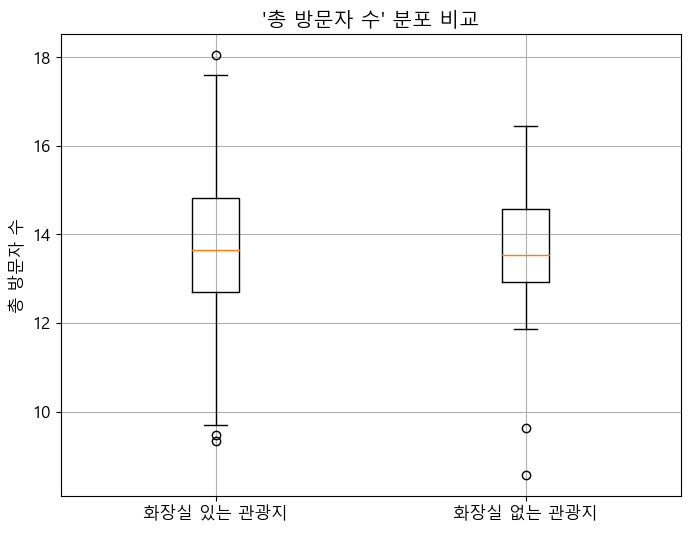

In [69]:
# '총 방문자 수' 로그 변환
has_toilet_df['log_총 방문자 수'] = has_toilet_df['총 방문자 수'].apply(lambda x: 0 if x == 0 else np.log(x + 1))
no_toilet_df['log_총 방문자 수'] = no_toilet_df['총 방문자 수'].apply(lambda x: 0 if x == 0 else np.log(x + 1))

# Box Plot 그리기
plt.figure(figsize=(8, 6))
plt.boxplot([has_toilet_df['log_총 방문자 수'], no_toilet_df['log_총 방문자 수']], labels=['화장실 있는 관광지','화장실 없는 관광지'])
plt.ylabel('총 방문자 수')
plt.title("'총 방문자 수' 분포 비교")
plt.grid(True)
plt.show()

In [70]:
# c.f.) 로그 변환 없이 Box Plot 그리기

# plt.figure(figsize=(8, 6))
# plt.boxplot([has_toilet_df['총 방문자 수'], no_toilet_df['총 방문자 수']], labels=['화장실 있는 관광지', '화장실 없는 관광지'])
# plt.ylabel('총 방문자 수')
# plt.title("'총 방문자 수' 분포 비교")
# plt.grid(True)
# plt.show()

In [71]:
# t-검정 전에 표본 수 확인
print(f'화장실 있는 관광지 개수 : {len(has_toilet_df)}')
print(f'화장실 없는 관광지 개수 : {len(no_toilet_df)}')

화장실 있는 관광지 개수 : 197
화장실 없는 관광지 개수 : 48


In [72]:
# 등분산 검정 (Levene's test)
statistic, p_value = stats.levene(has_toilet_df['총 방문자 수'], no_toilet_df['총 방문자 수'])

if p_value < 0.05:
    print("두 집단은 이분산 가정을 만족한다.")
    t_statistic, p_value = stats.ttest_ind(has_toilet_df['총 방문자 수'], no_toilet_df['총 방문자 수'], equal_var=False)
else:
    print("두 집단은 등분산 가정을 만족한다.")
    t_statistic, p_value = stats.ttest_ind(has_toilet_df['총 방문자 수'], no_toilet_df['총 방문자 수'], equal_var=True)

두 집단은 등분산 가정을 만족한다.


In [73]:
# 독립표본 t-검정 수행
t_statistic, p_value = ttest_ind(has_toilet_df['총 방문자 수'], no_toilet_df['총 방문자 수'])

print("\n독립표본 t-검정 결과:")
print("t-통계량:", t_statistic)
print("p-value:", p_value)


독립표본 t-검정 결과:
t-통계량: 1.0272771329460282
p-value: 0.3053114578718382


In [74]:
# 가설 검정 수행
if p_value < 0.05:
    print("\n'화장실 있는 관광지'와 '화장실 없는 관광지'의 '총 방문자 수'는 유의미한 차이가 있다.")
else:
    print("\n'화장실 있는 관광지'와 '화장실 없는 관광지'의 '총 방문자 수'는 유의미한 차이가 없다.")


'화장실 있는 관광지'와 '화장실 없는 관광지'의 '총 방문자 수'는 유의미한 차이가 없다.


## (2) '주차장' 가설

### ① 피어슨 상관계수 (Pearson correlation)
- H0 : 관광지의 '주차장' 유무는 '총 방문자 수'와 상관관계가 없다.
- H1 : 관광지의 '주차장' 유무는 '총 방문자 수'와 상관관계가 있다.

In [73]:
# '주차장' & '총 방문자 수' 컬럼 선택
selected_cols = ['주차장', '총 방문자 수']
parking_df = AB_merged_df[selected_cols]

In [74]:
# 상관계수 & p-value 계산
corr_coef, p_value = pearsonr(parking_df['주차장'], parking_df['총 방문자 수'])

print("상관계수:", corr_coef)
print("p-value:", p_value)

상관계수: 0.05129028383671534
p-value: 0.42415098470322016


In [75]:
# 가설 검정 수행
if p_value < 0.05:
    print("귀무가설(H0)을 기각. 관광지의 '주차장' 유무는 '총 방문자 수'와 상관관계가 있다.")
else:
    print("귀무가설(H0)을 채택. 관광지의 '주차장' 유무는 '총 방문자 수'와 상관관계가 없다.")

귀무가설(H0)을 채택. 관광지의 '주차장' 유무는 '총 방문자 수'와 상관관계가 없다.


### ② t-검정 (t-test)
- H0 : '주차장 있는 관광지'와 '주차장 없는 관광지'의 평균은 같다. (= 유의미한 차이가 없다.)
- H1 : '주차장 있는 관광지'와 '주차장 없는 관광지'의 평균은 다르다. (= 유의미한 차이가 있다.)

In [76]:
# '주차장 있는 관광지'와 '주차장 없는 관광지'를 분리하여 데이터프레임 생성
has_parking_df = AB_merged_df[AB_merged_df['주차장'] == 1]
no_parking_df = AB_merged_df[AB_merged_df['주차장'] == 0]

In [77]:
# 각 그룹의 '총 방문자 수' 분포 확인
print("주차장 있는 관광지:")
print(has_parking_df['총 방문자 수'].describe())

print("\n주차장 없는 관광지:")
print(no_parking_df['총 방문자 수'].describe())

주차장 있는 관광지:
count    1.450000e+02
mean     3.355646e+06
std      7.739465e+06
min      5.230000e+03
25%      3.332970e+05
50%      8.424690e+05
75%      2.757825e+06
max      6.821336e+07
Name: 총 방문자 수, dtype: float64

주차장 없는 관광지:
count    1.000000e+02
mean     2.653602e+06
std      4.957899e+06
min      1.129600e+04
25%      3.245315e+05
50%      7.951125e+05
75%      2.521168e+06
max      3.653624e+07
Name: 총 방문자 수, dtype: float64


C:\Users\Yon\AppData\Local\Temp\ipykernel_7912\1718155336.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  has_parking_df['log_총 방문자 수'] = has_parking_df['총 방문자 수'].apply(lambda x: 0 if x == 0 else np.log(x + 1))
C:\Users\Yon\AppData\Local\Temp\ipykernel_7912\1718155336.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_parking_df['log_총 방문자 수'] = no_parking_df['총 방문자 수'].apply(lambda x: 0 if x == 0 else np.log(x + 1))


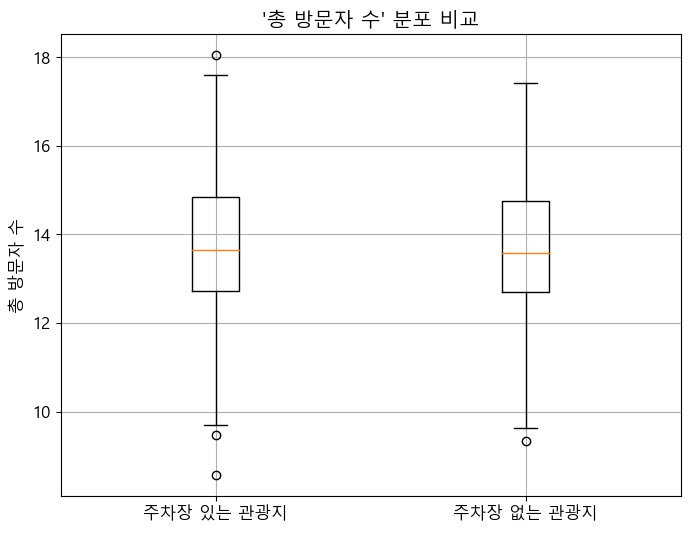

In [78]:
# '총 방문자 수' 로그 변환
has_parking_df['log_총 방문자 수'] = has_parking_df['총 방문자 수'].apply(lambda x: 0 if x == 0 else np.log(x + 1))
no_parking_df['log_총 방문자 수'] = no_parking_df['총 방문자 수'].apply(lambda x: 0 if x == 0 else np.log(x + 1))

# Box Plot 그리기
plt.figure(figsize=(8, 6))
plt.boxplot([has_parking_df['log_총 방문자 수'], no_parking_df['log_총 방문자 수']], labels=['주차장 있는 관광지','주차장 없는 관광지'])
plt.ylabel('총 방문자 수')
plt.title("'총 방문자 수' 분포 비교")
plt.grid(True)
plt.show()

In [79]:
# t-검정 전에 표본 수 확인
print(f'주차장 있는 관광지 개수 : {len(has_parking_df)}')
print(f'주차장 없는 관광지 개수 : {len(no_parking_df)}')

주차장 있는 관광지 개수 : 145
주차장 없는 관광지 개수 : 100


In [80]:
# 등분산 검정 (Levene's test)
statistic, p_value = stats.levene(has_parking_df['총 방문자 수'], no_parking_df['총 방문자 수'])

if p_value < 0.05:
    print("두 집단은 이분산 가정을 만족한다.")
    t_statistic, p_value = stats.ttest_ind(has_parking_df['총 방문자 수'], no_parking_df['총 방문자 수'], equal_var=False)
else:
    print("두 집단은 등분산 가정을 만족한다.")
    t_statistic, p_value = stats.ttest_ind(has_parking_df['총 방문자 수'], no_parking_df['총 방문자 수'], equal_var=True)

두 집단은 등분산 가정을 만족한다.


In [81]:
# 독립표본 t-검정 수행
t_statistic, p_value = ttest_ind(has_parking_df['총 방문자 수'], no_parking_df['총 방문자 수'])

print("\n독립표본 t-검정 결과:")
print("t-통계량:", t_statistic)
print("p-value:", p_value)


독립표본 t-검정 결과:
t-통계량: 0.8005901448675071
p-value: 0.4241509847030822


In [82]:
# 가설 검정 수행
if p_value < 0.05:
    print("\n'주차장 있는 관광지'와 '주차장 없는 관광지'의 '총 방문자 수'는 유의미한 차이가 있다.")
else:
    print("\n'주차장 있는 관광지'와 '주차장 없는 관광지'의 '총 방문자 수'는 유의미한 차이가 없다.")


'주차장 있는 관광지'와 '주차장 없는 관광지'의 '총 방문자 수'는 유의미한 차이가 없다.


## (3) '관리사무소' 가설

### ① 피어슨 상관계수 (Pearson correlation)
- H0 : 관광지의 '관리사무소' 유무는 '총 방문자 수'와 상관관계가 없다.
- H1 : 관광지의 '관리사무소' 유무는 '총 방문자 수'와 상관관계가 있다.

In [83]:
# '관리사무소' & '총 방문자 수' 컬럼 선택
selected_cols = ['관리사무소', '총 방문자 수']
office_df = AB_merged_df[selected_cols]

In [84]:
# 상관계수 & p-value 계산
corr_coef, p_value = pearsonr(office_df['관리사무소'], office_df['총 방문자 수'])

print("상관계수:", corr_coef)
print("p-value:", p_value)

상관계수: 0.07346368407724545
p-value: 0.2519786950247035


In [85]:
# 가설 검정 수행
if p_value < 0.05:
    print("귀무가설(H0)을 기각. 관광지의 '관리사무소' 유무는 '총 방문자 수'와 상관관계가 있다.")
else:
    print("귀무가설(H0)을 채택. 관광지의 '관리사무소' 유무는 '총 방문자 수'와 상관관계가 없다.")

귀무가설(H0)을 채택. 관광지의 '관리사무소' 유무는 '총 방문자 수'와 상관관계가 없다.


### ② t-검정 (t-test)
- H0 : '관리사무소 있는 관광지'와 '관리사무소 없는 관광지'의 평균은 같다. (= 유의미한 차이가 없다.)
- H1 : '관리사무소 있는 관광지'와 '관리사무소 없는 관광지'의 평균은 다르다. (= 유의미한 차이가 있다.)

In [86]:
# '관리사무소 있는 관광지'와 '관리사무소 없는 관광지'를 분리하여 데이터프레임 생성
has_office_df = AB_merged_df[AB_merged_df['관리사무소'] == 1]
no_office_df = AB_merged_df[AB_merged_df['관리사무소'] == 0]

In [87]:
# 각 그룹의 '총 방문자 수' 분포 확인
print("관리사무소 있는 관광지:")
print(has_office_df['총 방문자 수'].describe())

print("\n관리사무소 없는 관광지:")
print(no_office_df['총 방문자 수'].describe())

관리사무소 있는 관광지:
count    7.200000e+01
mean     3.835181e+06
std      6.784724e+06
min      1.310300e+04
25%      4.072788e+05
50%      8.393840e+05
75%      5.226911e+06
max      4.388696e+07
Name: 총 방문자 수, dtype: float64

관리사무소 없는 관광지:
count    1.730000e+02
mean     2.750265e+06
std      6.716873e+06
min      5.230000e+03
25%      3.231840e+05
50%      7.929980e+05
75%      2.482671e+06
max      6.821336e+07
Name: 총 방문자 수, dtype: float64


C:\Users\Yon\AppData\Local\Temp\ipykernel_7912\526120283.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  has_office_df['log_총 방문자 수'] = has_office_df['총 방문자 수'].apply(lambda x: 0 if x == 0 else np.log(x + 1))
C:\Users\Yon\AppData\Local\Temp\ipykernel_7912\526120283.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_office_df['log_총 방문자 수'] = no_office_df['총 방문자 수'].apply(lambda x: 0 if x == 0 else np.log(x + 1))


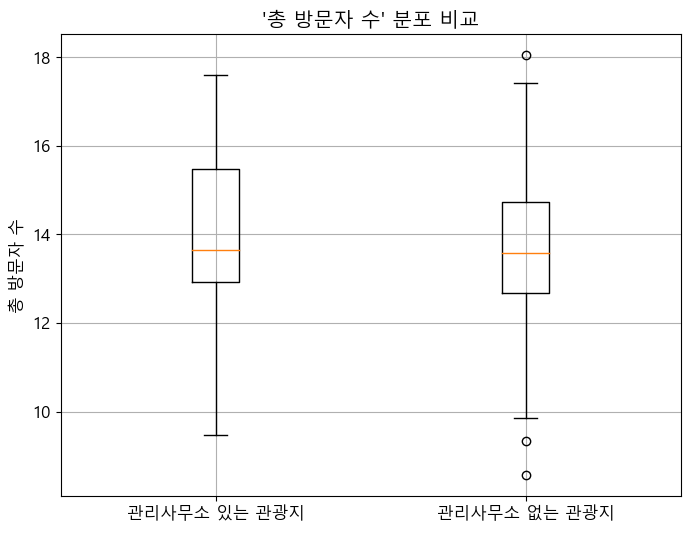

In [88]:
# '총 방문자 수' 로그 변환
has_office_df['log_총 방문자 수'] = has_office_df['총 방문자 수'].apply(lambda x: 0 if x == 0 else np.log(x + 1))
no_office_df['log_총 방문자 수'] = no_office_df['총 방문자 수'].apply(lambda x: 0 if x == 0 else np.log(x + 1))

# Box Plot 그리기
plt.figure(figsize=(8, 6))
plt.boxplot([has_office_df['log_총 방문자 수'], no_office_df['log_총 방문자 수']], labels=['관리사무소 있는 관광지','관리사무소 없는 관광지'])
plt.ylabel('총 방문자 수')
plt.title("'총 방문자 수' 분포 비교")
plt.grid(True)
plt.show()

In [89]:
# t-검정 전에 표본 수 확인
print(f'관리사무소 있는 관광지 개수 : {len(has_office_df)}')
print(f'관리사무소 없는 관광지 개수 : {len(no_office_df)}')

관리사무소 있는 관광지 개수 : 72
관리사무소 없는 관광지 개수 : 173


In [90]:
# 등분산 검정 (Levene's test)
statistic, p_value = stats.levene(has_office_df['총 방문자 수'], no_office_df['총 방문자 수'])

if p_value < 0.05:
    print("두 집단은 이분산 가정을 만족한다.")
    t_statistic, p_value = stats.ttest_ind(has_office_df['총 방문자 수'], no_office_df['총 방문자 수'], equal_var=False)
else:
    print("두 집단은 등분산 가정을 만족한다.")
    t_statistic, p_value = stats.ttest_ind(has_office_df['총 방문자 수'], no_office_df['총 방문자 수'], equal_var=True)

두 집단은 등분산 가정을 만족한다.


In [91]:
# 독립표본 t-검정 수행
t_statistic, p_value = ttest_ind(has_office_df['총 방문자 수'], no_office_df['총 방문자 수'])

print("\n독립표본 t-검정 결과:")
print("t-통계량:", t_statistic)
print("p-value:", p_value)


독립표본 t-검정 결과:
t-통계량: 1.1482882979947662
p-value: 0.25197869502461934


In [92]:
# 가설 검정 수행
if p_value < 0.05:
    print("\n'관리사무소 있는 관광지'와 '관리사무소 없는 관광지'의 '총 방문자 수'는 유의미한 차이가 있다.")
else:
    print("\n'관리사무소 있는 관광지'와 '관리사무소 없는 관광지'의 '총 방문자 수'는 유의미한 차이가 없다.")


'관리사무소 있는 관광지'와 '관리사무소 없는 관광지'의 '총 방문자 수'는 유의미한 차이가 없다.


## (4) '안내소' 가설

### ① 피어슨 상관계수 (Pearson correlation)
- H0 : 관광지의 '안내소' 유무는 '총 방문자 수'와 상관관계가 없다.
- H1 : 관광지의 '안내소' 유무는 '총 방문자 수'와 상관관계가 있다.

In [93]:
selected_cols = ['안내소', '총 방문자 수']
guide_df = AB_merged_df[selected_cols]

In [94]:
# 상관계수 & p-value 계산
corr_coef, p_value = pearsonr(guide_df['안내소'], guide_df['총 방문자 수'])

print("상관계수:", corr_coef)
print("p-value:", p_value)

상관계수: 0.3182446449254297
p-value: 3.604090645018242e-07


In [95]:
# 가설 검정 수행
if p_value < 0.05:
    print("귀무가설(H0)을 기각. 관광지의 '안내소' 유무는 '총 방문자 수'와 상관관계가 있다.")
else:
    print("귀무가설(H0)을 채택. 관광지의 '안내소' 유무는 '총 방문자 수'와 상관관계가 없다.")

귀무가설(H0)을 기각. 관광지의 '안내소' 유무는 '총 방문자 수'와 상관관계가 있다.


### ② t-검정 (t-test)
- H0 : '안내소 있는 관광지'와 '안내소 없는 관광지'의 평균은 같다. (= 유의미한 차이가 없다.)
- H1 : '안내소 있는 관광지'와 '안내소 없는 관광지'의 평균은 다르다. (= 유의미한 차이가 있다.)

In [96]:
has_guide_df = AB_merged_df[AB_merged_df['안내소'] == 1]
no_guide_df = AB_merged_df[AB_merged_df['안내소'] == 0]

In [97]:
# 각 그룹의 '총 방문자 수' 분포 확인
print("안내소 있는 관광지:")
print(has_guide_df['총 방문자 수'].describe())

print("\n안내소 없는 관광지:")
print(no_guide_df['총 방문자 수'].describe())

안내소 있는 관광지:
count    3.200000e+01
mean     8.592704e+06
std      1.461051e+07
min      4.696200e+04
25%      7.127140e+05
50%      2.750711e+06
75%      7.878819e+06
max      6.821336e+07
Name: 총 방문자 수, dtype: float64

안내소 없는 관광지:
count    2.130000e+02
mean     2.239260e+06
std      3.973782e+06
min      5.230000e+03
25%      3.264390e+05
50%      7.626110e+05
75%      2.358611e+06
max      3.653624e+07
Name: 총 방문자 수, dtype: float64


C:\Users\Yon\AppData\Local\Temp\ipykernel_7912\3386052540.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  has_guide_df['log_총 방문자 수'] = has_guide_df['총 방문자 수'].apply(lambda x: 0 if x == 0 else np.log(x + 1))
C:\Users\Yon\AppData\Local\Temp\ipykernel_7912\3386052540.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_guide_df['log_총 방문자 수'] = no_guide_df['총 방문자 수'].apply(lambda x: 0 if x == 0 else np.log(x + 1))


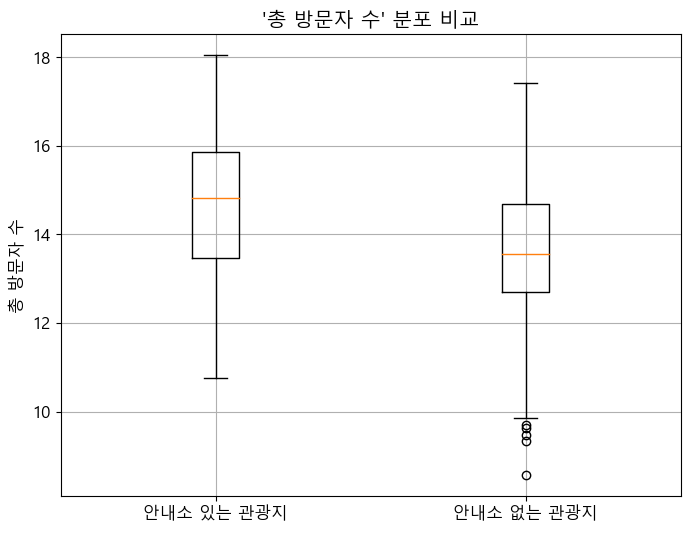

In [98]:
# '총 방문자 수' 로그 변환
has_guide_df['log_총 방문자 수'] = has_guide_df['총 방문자 수'].apply(lambda x: 0 if x == 0 else np.log(x + 1))
no_guide_df['log_총 방문자 수'] = no_guide_df['총 방문자 수'].apply(lambda x: 0 if x == 0 else np.log(x + 1))

# Box Plot 그리기
plt.figure(figsize=(8, 6))
plt.boxplot([has_guide_df['log_총 방문자 수'], no_guide_df['log_총 방문자 수']], labels=['안내소 있는 관광지','안내소 없는 관광지'])
plt.ylabel('총 방문자 수')
plt.title("'총 방문자 수' 분포 비교")
plt.grid(True)
plt.show()

In [99]:
# t-검정 전에 표본 수 확인
print(f'안내소 있는 관광지 개수 : {len(has_guide_df)}')
print(f'안내소 없는 관광지 개수 : {len(no_guide_df)}')

안내소 있는 관광지 개수 : 32
안내소 없는 관광지 개수 : 213


In [100]:
# 등분산 검정 (Levene's test)
statistic, p_value = stats.levene(has_guide_df['총 방문자 수'], no_guide_df['총 방문자 수'])

if p_value < 0.05:
    print("두 집단은 이분산 가정을 만족한다.")
    t_statistic, p_value = stats.ttest_ind(has_guide_df['총 방문자 수'], no_guide_df['총 방문자 수'], equal_var=False)
else:
    print("두 집단은 등분산 가정을 만족한다.")
    t_statistic, p_value = stats.ttest_ind(has_guide_df['총 방문자 수'], no_guide_df['총 방문자 수'], equal_var=True)

두 집단은 이분산 가정을 만족한다.


In [101]:
# 독립표본 t-검정 수행
t_statistic, p_value = ttest_ind(has_guide_df['총 방문자 수'], no_guide_df['총 방문자 수'])

print("\n독립표본 t-검정 결과:")
print("t-통계량:", t_statistic)
print("p-value:", p_value)


독립표본 t-검정 결과:
t-통계량: 5.233014697328143
p-value: 3.6040906450169547e-07


In [102]:
# 가설 검정 수행
if p_value < 0.05:
    print("\n'안내소 있는 관광지'와 '안내소 없는 관광지'의 '총 방문자 수'는 유의미한 차이가 있다.")
else:
    print("\n'안내소 있는 관광지'와 '안내소 없는 관광지'의 '총 방문자 수'는 유의미한 차이가 없다.")


'안내소 있는 관광지'와 '안내소 없는 관광지'의 '총 방문자 수'는 유의미한 차이가 있다.


## (5) '샤워장' 가설

### ① 피어슨 상관계수 (Pearson correlation)
- H0 : 관광지의 '샤워장' 유무는 '총 방문자 수'와 상관관계가 없다.
- H1 : 관광지의 '샤워장' 유무는 '총 방문자 수'와 상관관계가 있다.

In [103]:
selected_cols = ['샤워장', '총 방문자 수']
shower_df = AB_merged_df[selected_cols]

In [104]:
# 상관계수 & p-value 계산
corr_coef, p_value = pearsonr(shower_df['샤워장'], shower_df['총 방문자 수'])

print("상관계수:", corr_coef)
print("p-value:", p_value)

상관계수: -0.016580526073041515
p-value: 0.7962395900806146


In [105]:
# 가설 검정 수행
if p_value < 0.05:
    print("귀무가설(H0)을 기각. 관광지의 '샤워장' 유무는 '총 방문자 수'와 상관관계가 있다.")
else:
    print("귀무가설(H0)을 채택. 관광지의 '샤워장' 유무는 '총 방문자 수'와 상관관계가 없다.")

귀무가설(H0)을 채택. 관광지의 '샤워장' 유무는 '총 방문자 수'와 상관관계가 없다.


### ② t-검정 (t-test)
- H0 : '샤워장 있는 관광지'와 '샤워장 없는 관광지'의 평균은 같다. (= 유의미한 차이가 없다.)
- H1 : '샤워장 있는 관광지'와 '샤워장 없는 관광지'의 평균은 다르다. (= 유의미한 차이가 있다.)

In [106]:
has_shower_df = AB_merged_df[AB_merged_df['샤워장'] == 1]
no_shower_df = AB_merged_df[AB_merged_df['샤워장'] == 0]

In [107]:
# 각 그룹의 '총 방문자 수' 분포 확인
print("샤워장 있는 관광지:")
print(has_shower_df['총 방문자 수'].describe())

print("\n샤워장 없는 관광지:")
print(no_shower_df['총 방문자 수'].describe())

샤워장 있는 관광지:
count    1.400000e+01
mean     2.616005e+06
std      6.735769e+06
min      9.930100e+04
25%      2.496272e+05
50%      6.270505e+05
75%      1.173587e+06
max      2.577988e+07
Name: 총 방문자 수, dtype: float64

샤워장 없는 관광지:
count    2.310000e+02
mean     3.096558e+06
std      6.755127e+06
min      5.230000e+03
25%      3.348965e+05
50%      8.320980e+05
75%      2.726879e+06
max      6.821336e+07
Name: 총 방문자 수, dtype: float64


C:\Users\Yon\AppData\Local\Temp\ipykernel_7912\2160756257.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  has_shower_df['log_총 방문자 수'] = has_shower_df['총 방문자 수'].apply(lambda x: 0 if x == 0 else np.log(x + 1))
C:\Users\Yon\AppData\Local\Temp\ipykernel_7912\2160756257.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_shower_df['log_총 방문자 수'] = no_shower_df['총 방문자 수'].apply(lambda x: 0 if x == 0 else np.log(x + 1))


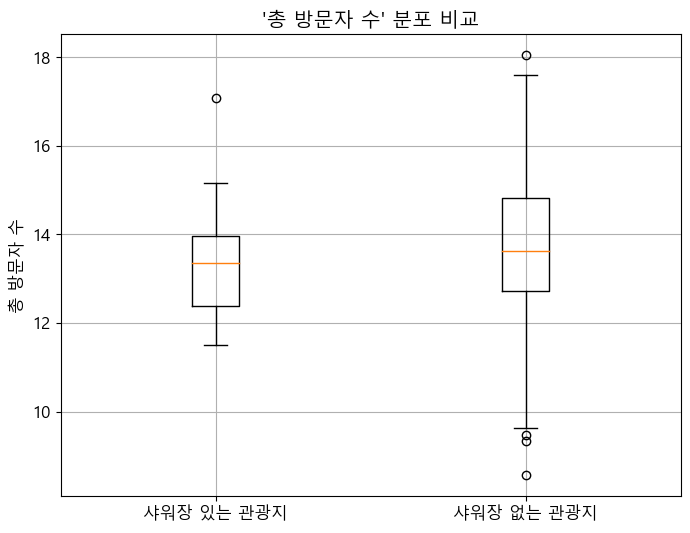

In [108]:
# '총 방문자 수' 로그 변환
has_shower_df['log_총 방문자 수'] = has_shower_df['총 방문자 수'].apply(lambda x: 0 if x == 0 else np.log(x + 1))
no_shower_df['log_총 방문자 수'] = no_shower_df['총 방문자 수'].apply(lambda x: 0 if x == 0 else np.log(x + 1))

# Box Plot 그리기
plt.figure(figsize=(8, 6))
plt.boxplot([has_shower_df['log_총 방문자 수'], no_shower_df['log_총 방문자 수']], labels=['샤워장 있는 관광지','샤워장 없는 관광지'])
plt.ylabel('총 방문자 수')
plt.title("'총 방문자 수' 분포 비교")
plt.grid(True)
plt.show()

In [109]:
# t-검정 전에 표본 수 확인
print(f'샤워장 있는 관광지 개수 : {len(has_shower_df)}')
print(f'샤워장 없는 관광지 개수 : {len(no_shower_df)}')

샤워장 있는 관광지 개수 : 14
샤워장 없는 관광지 개수 : 231


In [110]:
# 등분산 검정 (Levene's test)
statistic, p_value = stats.levene(has_shower_df['총 방문자 수'], no_shower_df['총 방문자 수'])

if p_value < 0.05:
    print("두 집단은 이분산 가정을 만족한다.")
    t_statistic, p_value = stats.ttest_ind(has_shower_df['총 방문자 수'], no_shower_df['총 방문자 수'], equal_var=False)
else:
    print("두 집단은 등분산 가정을 만족한다.")
    t_statistic, p_value = stats.ttest_ind(has_shower_df['총 방문자 수'], no_shower_df['총 방문자 수'], equal_var=True)

두 집단은 등분산 가정을 만족한다.


In [111]:
# 독립표본 t-검정 수행
t_statistic, p_value = ttest_ind(has_shower_df['총 방문자 수'], no_shower_df['총 방문자 수'])

print("\n독립표본 t-검정 결과:")
print("t-통계량:", t_statistic)
print("p-value:", p_value)


독립표본 t-검정 결과:
t-통계량: -0.2585003572785549
p-value: 0.7962395900803516


In [112]:
# 가설 검정 수행
if p_value < 0.05:
    print("\n'샤워장 있는 관광지'와 '샤워장 없는 관광지'의 '총 방문자 수'는 유의미한 차이가 있다.")
else:
    print("\n'샤워장 있는 관광지'와 '샤워장 없는 관광지'의 '총 방문자 수'는 유의미한 차이가 없다.")


'샤워장 있는 관광지'와 '샤워장 없는 관광지'의 '총 방문자 수'는 유의미한 차이가 없다.


## (6) '광장' 가설

### ① 피어슨 상관계수 (Pearson correlation)
- H0 : 관광지의 '광장' 유무는 '총 방문자 수'와 상관관계가 없다.
- H1 : 관광지의 '광장' 유무는 '총 방문자 수'와 상관관계가 있다.

In [113]:
selected_cols = ['광장', '총 방문자 수']
plaza_df = AB_merged_df[selected_cols]

In [114]:
# 상관계수 & p-value 계산
corr_coef, p_value = pearsonr(plaza_df['광장'], plaza_df['총 방문자 수'])

print("상관계수:", corr_coef)
print("p-value:", p_value)

상관계수: 0.16452439106295488
p-value: 0.00989014172674206


In [115]:
# 가설 검정 수행
if p_value < 0.05:
    print("귀무가설(H0)을 기각. 관광지의 '광장' 유무는 '총 방문자 수'와 상관관계가 있다.")
else:
    print("귀무가설(H0)을 채택. 관광지의 '광장' 유무는 '총 방문자 수'와 상관관계가 없다.")

귀무가설(H0)을 기각. 관광지의 '광장' 유무는 '총 방문자 수'와 상관관계가 있다.


### ② t-검정 (t-test)
- H0 : '관리사무소 있는 관광지'와 '관리사무소 없는 관광지'의 평균은 같다. (= 유의미한 차이가 없다.)
- H1 : '관리사무소 있는 관광지'와 '관리사무소 없는 관광지'의 평균은 다르다. (= 유의미한 차이가 있다.)

In [116]:
has_plaza_df = AB_merged_df[AB_merged_df['광장'] == 1]
no_plaza_df = AB_merged_df[AB_merged_df['광장'] == 0]

In [117]:
# 각 그룹의 '총 방문자 수' 분포 확인
print("광장 있는 관광지:")
print(has_plaza_df['총 방문자 수'].describe())

print("\n광장 없는 관광지:")
print(no_plaza_df['총 방문자 수'].describe())

광장 있는 관광지:
count    9.000000e+00
mean     8.736863e+06
std      1.382938e+07
min      6.454850e+05
25%      1.141978e+06
50%      3.469450e+06
75%      6.885530e+06
max      4.388696e+07
Name: 총 방문자 수, dtype: float64

광장 없는 관광지:
count    2.360000e+02
mean     2.852954e+06
std      6.276608e+06
min      5.230000e+03
25%      3.307530e+05
50%      7.960615e+05
75%      2.613632e+06
max      6.821336e+07
Name: 총 방문자 수, dtype: float64


C:\Users\Yon\AppData\Local\Temp\ipykernel_7912\2727742219.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  has_plaza_df['log_총 방문자 수'] = has_plaza_df['총 방문자 수'].apply(lambda x: 0 if x == 0 else np.log(x + 1))
C:\Users\Yon\AppData\Local\Temp\ipykernel_7912\2727742219.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_plaza_df['log_총 방문자 수'] = no_plaza_df['총 방문자 수'].apply(lambda x: 0 if x == 0 else np.log(x + 1))


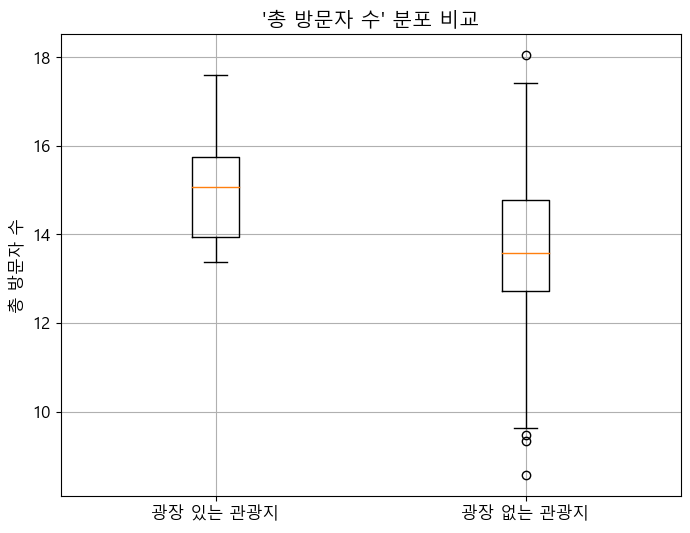

In [118]:
# '총 방문자 수' 로그 변환
has_plaza_df['log_총 방문자 수'] = has_plaza_df['총 방문자 수'].apply(lambda x: 0 if x == 0 else np.log(x + 1))
no_plaza_df['log_총 방문자 수'] = no_plaza_df['총 방문자 수'].apply(lambda x: 0 if x == 0 else np.log(x + 1))

# Box Plot 그리기
plt.figure(figsize=(8, 6))
plt.boxplot([has_plaza_df['log_총 방문자 수'], no_plaza_df['log_총 방문자 수']], labels=['광장 있는 관광지','광장 없는 관광지'])
plt.ylabel('총 방문자 수')
plt.title("'총 방문자 수' 분포 비교")
plt.grid(True)
plt.show()

In [119]:
# t-검정 전에 표본 수 확인
print(f'광장 있는 관광지 개수 : {len(has_plaza_df)}')
print(f'광장 없는 관광지 개수 : {len(no_plaza_df)}')

광장 있는 관광지 개수 : 9
광장 없는 관광지 개수 : 236


In [120]:
# 등분산 검정 (Levene's test)
statistic, p_value = stats.levene(has_plaza_df['총 방문자 수'], no_plaza_df['총 방문자 수'])

if p_value < 0.05:
    print("두 집단은 이분산 가정을 만족한다.")
    t_statistic, p_value = stats.ttest_ind(has_plaza_df['총 방문자 수'], no_plaza_df['총 방문자 수'], equal_var=False)
else:
    print("두 집단은 등분산 가정을 만족한다.")
    t_statistic, p_value = stats.ttest_ind(has_plaza_df['총 방문자 수'], no_plaza_df['총 방문자 수'], equal_var=True)

두 집단은 이분산 가정을 만족한다.


In [121]:
# 독립표본 t-검정 수행
t_statistic, p_value = ttest_ind(has_plaza_df['총 방문자 수'], no_plaza_df['총 방문자 수'])

print("\n독립표본 t-검정 결과:")
print("t-통계량:", t_statistic)
print("p-value:", p_value)


독립표본 t-검정 결과:
t-통계량: 2.6001131424049952
p-value: 0.009890141726738603


In [122]:
# 가설 검정 수행
if p_value < 0.05:
    print("\n'광장 있는 관광지'와 '광장 없는 관광지'의 '총 방문자 수'는 유의미한 차이가 있다.")
else:
    print("\n'광장 있는 관광지'와 '광장 없는 관광지'의 '총 방문자 수'는 유의미한 차이가 없다.")


'광장 있는 관광지'와 '광장 없는 관광지'의 '총 방문자 수'는 유의미한 차이가 있다.


## (7) '수유실' 가설

### ① 피어슨 상관계수 (Pearson correlation)
- H0 : 관광지의 '수유실' 유무는 '총 방문자 수'와 상관관계가 없다.
- H1 : 관광지의 '수유실' 유무는 '총 방문자 수'와 상관관계가 있다.

In [123]:
selected_cols = ['수유실', '총 방문자 수']
feeding_df = AB_merged_df[selected_cols]

In [124]:
# 상관계수 & p-value 계산
corr_coef, p_value = pearsonr(feeding_df['수유실'], feeding_df['총 방문자 수'])

print("상관계수:", corr_coef)
print("p-value:", p_value)

상관계수: -0.00019488896524577116
p-value: 0.9975785083174715


In [125]:
# 가설 검정 수행
if p_value < 0.05:
    print("귀무가설(H0)을 기각. 관광지의 '수유실' 유무는 '총 방문자 수'와 상관관계가 있다.")
else:
    print("귀무가설(H0)을 채택. 관광지의 '수유실' 유무는 '총 방문자 수'와 상관관계가 없다.")

귀무가설(H0)을 채택. 관광지의 '수유실' 유무는 '총 방문자 수'와 상관관계가 없다.


### ② t-검정 (t-test)
- H0 : '수유실 있는 관광지'와 '수유실 없는 관광지'의 평균은 같다. (= 유의미한 차이가 없다.)
- H1 : '수유실 있는 관광지'와 '수유실 없는 관광지'의 평균은 다르다. (= 유의미한 차이가 있다.)

In [126]:
has_feeding_df = AB_merged_df[AB_merged_df['수유실'] == 1]
no_feeding_df = AB_merged_df[AB_merged_df['수유실'] == 0]

In [127]:
# 각 그룹의 '총 방문자 수' 분포 확인
print("수유실 있는 관광지:")
print(has_feeding_df['총 방문자 수'].describe())

print("\n수유실 없는 관광지:")
print(no_feeding_df['총 방문자 수'].describe())

수유실 있는 관광지:
count    1.000000e+01
mean     3.062742e+06
std      4.503927e+06
min      1.569250e+05
25%      3.250362e+05
50%      7.602735e+05
75%      3.426534e+06
max      1.143002e+07
Name: 총 방문자 수, dtype: float64

수유실 없는 관광지:
count    2.350000e+02
mean     3.069368e+06
std      6.826794e+06
min      5.230000e+03
25%      3.348965e+05
50%      8.228070e+05
75%      2.704791e+06
max      6.821336e+07
Name: 총 방문자 수, dtype: float64


C:\Users\Yon\AppData\Local\Temp\ipykernel_7912\623850197.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  has_feeding_df['log_총 방문자 수'] = has_feeding_df['총 방문자 수'].apply(lambda x: 0 if x == 0 else np.log(x + 1))
C:\Users\Yon\AppData\Local\Temp\ipykernel_7912\623850197.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_feeding_df['log_총 방문자 수'] = no_feeding_df['총 방문자 수'].apply(lambda x: 0 if x == 0 else np.log(x + 1))


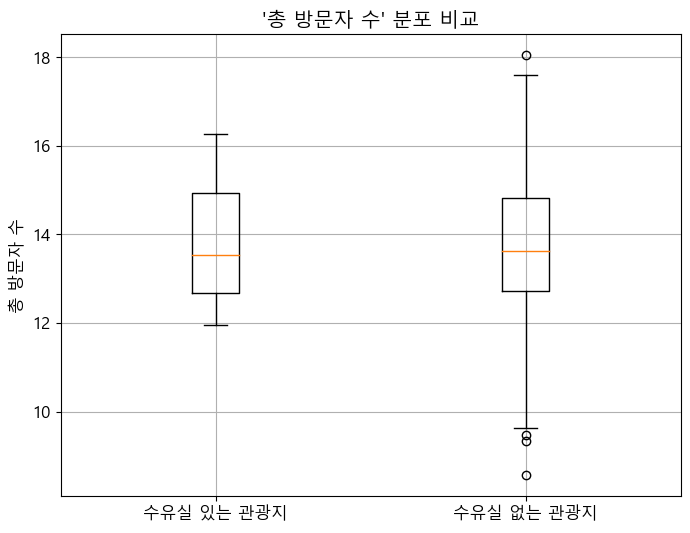

In [128]:
# '총 방문자 수' 로그 변환
has_feeding_df['log_총 방문자 수'] = has_feeding_df['총 방문자 수'].apply(lambda x: 0 if x == 0 else np.log(x + 1))
no_feeding_df['log_총 방문자 수'] = no_feeding_df['총 방문자 수'].apply(lambda x: 0 if x == 0 else np.log(x + 1))

# Box Plot 그리기
plt.figure(figsize=(8, 6))
plt.boxplot([has_feeding_df['log_총 방문자 수'], no_feeding_df['log_총 방문자 수']], labels=['수유실 있는 관광지','수유실 없는 관광지'])
plt.ylabel('총 방문자 수')
plt.title("'총 방문자 수' 분포 비교")
plt.grid(True)
plt.show()

In [129]:
# t-검정 전에 표본 수 확인
print(f'수유실 있는 관광지 개수 : {len(has_feeding_df)}')
print(f'수유실 없는 관광지 개수 : {len(no_feeding_df)}')

수유실 있는 관광지 개수 : 10
수유실 없는 관광지 개수 : 235


In [130]:
# 등분산 검정 (Levene's test)
statistic, p_value = stats.levene(has_feeding_df['총 방문자 수'], no_feeding_df['총 방문자 수'])

if p_value < 0.05:
    print("두 집단은 이분산 가정을 만족한다.")
    t_statistic, p_value = stats.ttest_ind(has_feeding_df['총 방문자 수'], no_feeding_df['총 방문자 수'], equal_var=False)
else:
    print("두 집단은 등분산 가정을 만족한다.")
    t_statistic, p_value = stats.ttest_ind(has_feeding_df['총 방문자 수'], no_feeding_df['총 방문자 수'], equal_var=True)

두 집단은 등분산 가정을 만족한다.


In [131]:
# 독립표본 t-검정 수행
t_statistic, p_value = ttest_ind(has_feeding_df['총 방문자 수'], no_feeding_df['총 방문자 수'])

print("\n독립표본 t-검정 결과:")
print("t-통계량:", t_statistic)
print("p-value:", p_value)


독립표본 t-검정 결과:
t-통계량: -0.0030380183644563145
p-value: 0.9975785083171196


In [132]:
# 가설 검정 수행
if p_value < 0.05:
    print("\n'수유실 있는 관광지'와 '수유실 없는 관광지'의 '총 방문자 수'는 유의미한 차이가 있다.")
else:
    print("\n'수유실 있는 관광지'와 '수유실 없는 관광지'의 '총 방문자 수'는 유의미한 차이가 없다.")


'수유실 있는 관광지'와 '수유실 없는 관광지'의 '총 방문자 수'는 유의미한 차이가 없다.


## (8) '휴게/쉼터' 가설

### ① 피어슨 상관계수 (Pearson correlation)
- H0 : 관광지의 '휴게/쉼터' 유무는 '총 방문자 수'와 상관관계가 없다.
- H1 : 관광지의 '휴게/쉼터' 유무는 '총 방문자 수'와 상관관계가 있다.

In [133]:
selected_cols = ['휴게/쉼터', '총 방문자 수']
rest_df = AB_merged_df[selected_cols]

In [134]:
# 상관계수 & p-value 계산
corr_coef, p_value = pearsonr(rest_df['휴게/쉼터'], rest_df['총 방문자 수'])

print("상관계수:", corr_coef)
print("p-value:", p_value)

상관계수: -0.052108077492514386
p-value: 0.41679099383680196


In [135]:
# 가설 검정 수행
if p_value < 0.05:
    print("귀무가설(H0)을 기각. 관광지의 '휴게/쉼터' 유무는 '총 방문자 수'와 상관관계가 있다.")
else:
    print("귀무가설(H0)을 채택. 관광지의 '휴게/쉼터' 유무는 '총 방문자 수'와 상관관계가 없다.")

귀무가설(H0)을 채택. 관광지의 '휴게/쉼터' 유무는 '총 방문자 수'와 상관관계가 없다.


### ② t-검정 (t-test)
- H0 : '휴게/쉼터 있는 관광지'와 '휴게/쉼터 없는 관광지'의 평균은 같다. (= 유의미한 차이가 없다.)
- H1 : '휴게/쉼터 있는 관광지'와 '휴게/쉼터 없는 관광지'의 평균은 다르다. (= 유의미한 차이가 있다.)

In [136]:
has_rest_df = AB_merged_df[AB_merged_df['휴게/쉼터'] == 1]
no_rest_df = AB_merged_df[AB_merged_df['휴게/쉼터'] == 0]

In [137]:
# 각 그룹의 '총 방문자 수' 분포 확인
print("휴게/쉼터 있는 관광지:")
print(has_rest_df['총 방문자 수'].describe())

print("\n휴게/쉼터 없는 관광지:")
print(no_rest_df['총 방문자 수'].describe())

휴게/쉼터 있는 관광지:
count    1.000000e+01
mean     1.369736e+06
std      1.366894e+06
min      3.613200e+04
25%      2.199838e+05
50%      9.347855e+05
75%      2.346680e+06
max      3.948161e+06
Name: 총 방문자 수, dtype: float64

휴게/쉼터 없는 관광지:
count    2.350000e+02
mean     3.141411e+06
std      6.869119e+06
min      5.230000e+03
25%      3.398750e+05
50%      8.192590e+05
75%      2.717170e+06
max      6.821336e+07
Name: 총 방문자 수, dtype: float64


C:\Users\Yon\AppData\Local\Temp\ipykernel_7912\4062433342.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  has_rest_df['log_총 방문자 수'] = has_rest_df['총 방문자 수'].apply(lambda x: 0 if x == 0 else np.log(x + 1))
C:\Users\Yon\AppData\Local\Temp\ipykernel_7912\4062433342.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_rest_df['log_총 방문자 수'] = no_rest_df['총 방문자 수'].apply(lambda x: 0 if x == 0 else np.log(x + 1))


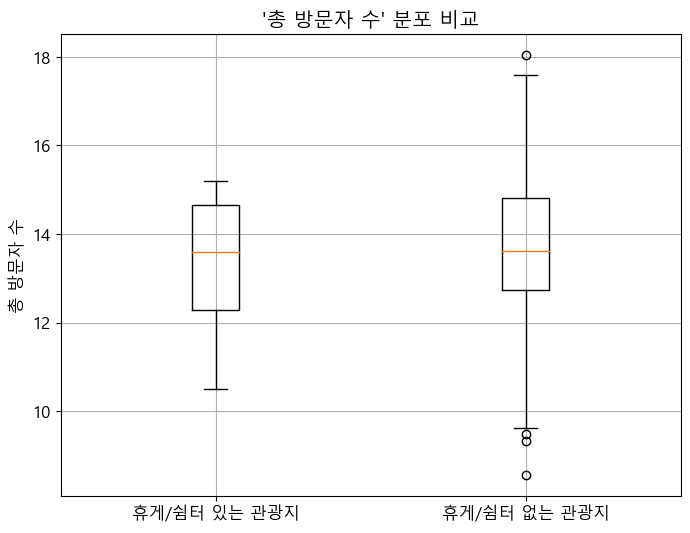

In [138]:
# '총 방문자 수' 로그 변환
has_rest_df['log_총 방문자 수'] = has_rest_df['총 방문자 수'].apply(lambda x: 0 if x == 0 else np.log(x + 1))
no_rest_df['log_총 방문자 수'] = no_rest_df['총 방문자 수'].apply(lambda x: 0 if x == 0 else np.log(x + 1))

# Box Plot 그리기
plt.figure(figsize=(8, 6))
plt.boxplot([has_rest_df['log_총 방문자 수'], no_rest_df['log_총 방문자 수']], labels=['휴게/쉼터 있는 관광지','휴게/쉼터 없는 관광지'])
plt.ylabel('총 방문자 수')
plt.title("'총 방문자 수' 분포 비교")
plt.grid(True)
plt.show()

In [139]:
# t-검정 전에 표본 수 확인
print(f'휴게/쉼터 있는 관광지 개수 : {len(has_rest_df)}')
print(f'휴게/쉼터 없는 관광지 개수 : {len(no_rest_df)}')

휴게/쉼터 있는 관광지 개수 : 10
휴게/쉼터 없는 관광지 개수 : 235


In [140]:
# 등분산 검정 (Levene's test)
statistic, p_value = stats.levene(has_rest_df['총 방문자 수'], no_rest_df['총 방문자 수'])

if p_value < 0.05:
    print("두 집단은 이분산 가정을 만족한다.")
    t_statistic, p_value = stats.ttest_ind(has_rest_df['총 방문자 수'], no_rest_df['총 방문자 수'], equal_var=False)
else:
    print("두 집단은 등분산 가정을 만족한다.")
    t_statistic, p_value = stats.ttest_ind(has_rest_df['총 방문자 수'], no_rest_df['총 방문자 수'], equal_var=True)

두 집단은 등분산 가정을 만족한다.


In [141]:
# 독립표본 t-검정 수행
t_statistic, p_value = ttest_ind(has_rest_df['총 방문자 수'], no_rest_df['총 방문자 수'])

print("\n독립표본 t-검정 결과:")
print("t-통계량:", t_statistic)
print("p-value:", p_value)


독립표본 t-검정 결과:
t-통계량: -0.8133895686548052
p-value: 0.4167909938366713


In [142]:
# 가설 검정 수행
if p_value < 0.05:
    print("\n'휴게/쉼터 있는 관광지'와 '휴게/쉼터 없는 관광지'의 '총 방문자 수'는 유의미한 차이가 있다.")
else:
    print("\n'휴게/쉼터 있는 관광지'와 '휴게/쉼터 없는 관광지'의 '총 방문자 수'는 유의미한 차이가 없다.")


'휴게/쉼터 있는 관광지'와 '휴게/쉼터 없는 관광지'의 '총 방문자 수'는 유의미한 차이가 없다.


## (9) '공원' 가설

### ① 피어슨 상관계수 (Pearson correlation)
- H0 : 관광지의 '공원' 유무는 '총 방문자 수'와 상관관계가 없다.
- H1 : 관광지의 '공원' 유무는 '총 방문자 수'와 상관관계가 있다.

In [143]:
selected_cols = ['공원', '총 방문자 수']
park_df = AB_merged_df[selected_cols]

In [144]:
# 상관계수 & p-value 계산
corr_coef, p_value = pearsonr(park_df['공원'], park_df['총 방문자 수'])

print("상관계수:", corr_coef)
print("p-value:", p_value)

상관계수: -0.04464152404084802
p-value: 0.4867271242004927


In [145]:
# 가설 검정 수행
if p_value < 0.05:
    print("귀무가설(H0)을 기각. 관광지의 '공원' 유무는 '총 방문자 수'와 상관관계가 있다.")
else:
    print("귀무가설(H0)을 채택. 관광지의 '공원' 유무는 '총 방문자 수'와 상관관계가 없다.")

귀무가설(H0)을 채택. 관광지의 '공원' 유무는 '총 방문자 수'와 상관관계가 없다.


### ② t-검정 (t-test)
- H0 : '휴게/쉼터 있는 관광지'와 '휴게/쉼터 없는 관광지'의 평균은 같다. (= 유의미한 차이가 없다.)
- H1 : '휴게/쉼터 있는 관광지'와 '휴게/쉼터 없는 관광지'의 평균은 다르다. (= 유의미한 차이가 있다.)

In [146]:
has_park_df = AB_merged_df[AB_merged_df['공원'] == 1]
no_park_df = AB_merged_df[AB_merged_df['공원'] == 0]

In [147]:
# 각 그룹의 '총 방문자 수' 분포 확인
print("공원 있는 관광지:")
print(has_park_df['총 방문자 수'].describe())

print("\n공원 없는 관광지:")
print(no_park_df['총 방문자 수'].describe())

공원 있는 관광지:
count    7.000000e+00
mean     1.317940e+06
std      1.492321e+06
min      3.332970e+05
25%      3.513075e+05
50%      6.416570e+05
75%      1.799924e+06
max      3.948161e+06
Name: 총 방문자 수, dtype: float64

공원 없는 관광지:
count    2.380000e+02
mean     3.120602e+06
std      6.829048e+06
min      5.230000e+03
25%      3.332672e+05
50%      8.274525e+05
75%      2.707254e+06
max      6.821336e+07
Name: 총 방문자 수, dtype: float64


C:\Users\Yon\AppData\Local\Temp\ipykernel_7912\3126378262.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  has_park_df['log_총 방문자 수'] = has_park_df['총 방문자 수'].apply(lambda x: 0 if x == 0 else np.log(x + 1))
C:\Users\Yon\AppData\Local\Temp\ipykernel_7912\3126378262.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_park_df['log_총 방문자 수'] = no_park_df['총 방문자 수'].apply(lambda x: 0 if x == 0 else np.log(x + 1))


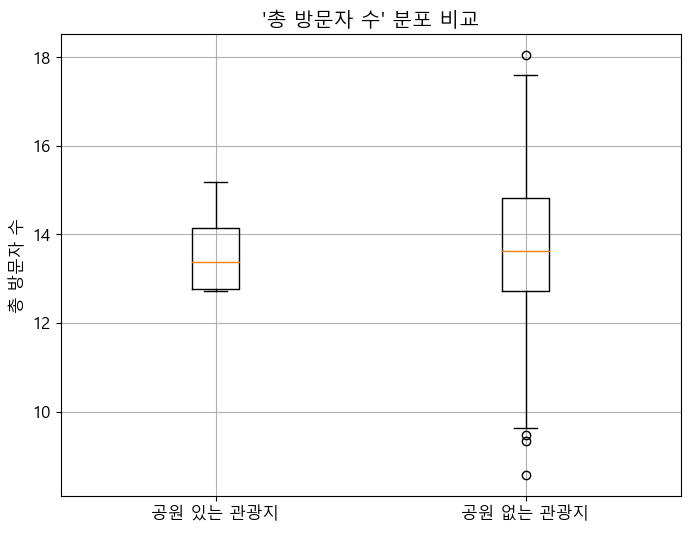

In [148]:
# '총 방문자 수' 로그 변환
has_park_df['log_총 방문자 수'] = has_park_df['총 방문자 수'].apply(lambda x: 0 if x == 0 else np.log(x + 1))
no_park_df['log_총 방문자 수'] = no_park_df['총 방문자 수'].apply(lambda x: 0 if x == 0 else np.log(x + 1))

# Box Plot 그리기
plt.figure(figsize=(8, 6))
plt.boxplot([has_park_df['log_총 방문자 수'], no_park_df['log_총 방문자 수']], labels=['공원 있는 관광지','공원 없는 관광지'])
plt.ylabel('총 방문자 수')
plt.title("'총 방문자 수' 분포 비교")
plt.grid(True)
plt.show()

In [149]:
# t-검정 전에 표본 수 확인
print(f'공원 있는 관광지 개수 : {len(has_park_df)}')
print(f'공원 없는 관광지 개수 : {len(no_park_df)}')

공원 있는 관광지 개수 : 7
공원 없는 관광지 개수 : 238


In [150]:
# 등분산 검정 (Levene's test)
statistic, p_value = stats.levene(has_park_df['총 방문자 수'], no_park_df['총 방문자 수'])

if p_value < 0.05:
    print("두 집단은 이분산 가정을 만족한다.")
    t_statistic, p_value = stats.ttest_ind(has_park_df['총 방문자 수'], no_park_df['총 방문자 수'], equal_var=False)
else:
    print("두 집단은 등분산 가정을 만족한다.")
    t_statistic, p_value = stats.ttest_ind(has_park_df['총 방문자 수'], no_park_df['총 방문자 수'], equal_var=True)

두 집단은 등분산 가정을 만족한다.


In [151]:
# 독립표본 t-검정 수행
t_statistic, p_value = ttest_ind(has_park_df['총 방문자 수'], no_park_df['총 방문자 수'])

print("\n독립표본 t-검정 결과:")
print("t-통계량:", t_statistic)
print("p-value:", p_value)


독립표본 t-검정 결과:
t-통계량: -0.6965869381497236
p-value: 0.4867271242003246


In [152]:
# 가설 검정 수행
if p_value < 0.05:
    print("\n'공원 있는 관광지'와 '공원 없는 관광지'의 '총 방문자 수'는 유의미한 차이가 있다.")
else:
    print("\n'공원 있는 관광지'와 '공원 없는 관광지'의 '총 방문자 수'는 유의미한 차이가 없다.")


'공원 있는 관광지'와 '공원 없는 관광지'의 '총 방문자 수'는 유의미한 차이가 없다.


## (10) '카페/커피' 가설

### ① 피어슨 상관계수 (Pearson correlation)
- H0 : 관광지의 '카페/커피' 유무는 '총 방문자 수'와 상관관계가 없다.
- H1 : 관광지의 '카페/커피' 유무는 '총 방문자 수'와 상관관계가 있다.

In [153]:
selected_cols = ['카페/커피', '총 방문자 수']
coffee_df = AB_merged_df[selected_cols]

In [154]:
# 상관계수 & p-value 계산
corr_coef, p_value = pearsonr(coffee_df['카페/커피'], coffee_df['총 방문자 수'])

print("상관계수:", corr_coef)
print("p-value:", p_value)

상관계수: 0.0017385492756924643
p-value: 0.978401147655602


In [155]:
# 가설 검정 수행
if p_value < 0.05:
    print("귀무가설(H0)을 기각. 관광지의 '카페/커피' 유무는 '총 방문자 수'와 상관관계가 있다.")
else:
    print("귀무가설(H0)을 채택. 관광지의 '카페/커피' 유무는 '총 방문자 수'와 상관관계가 없다.")

귀무가설(H0)을 채택. 관광지의 '카페/커피' 유무는 '총 방문자 수'와 상관관계가 없다.


### ② t-검정 (t-test)
- H0 : '휴게/쉼터 있는 관광지'와 '휴게/쉼터 없는 관광지'의 평균은 같다. (= 유의미한 차이가 없다.)
- H1 : '휴게/쉼터 있는 관광지'와 '휴게/쉼터 없는 관광지'의 평균은 다르다. (= 유의미한 차이가 있다.)

In [156]:
has_coffee_df = AB_merged_df[AB_merged_df['카페/커피'] == 1]
no_coffee_df = AB_merged_df[AB_merged_df['카페/커피'] == 0]

In [157]:
# 각 그룹의 '총 방문자 수' 분포 확인
print("카페/커피 있는 관광지:")
print(has_coffee_df['총 방문자 수'].describe())

print("\n카페/커피 없는 관광지:")
print(no_coffee_df['총 방문자 수'].describe())

카페/커피 있는 관광지:
count    4.000000e+00
mean     3.159882e+06
std      3.520101e+06
min      2.003900e+05
25%      1.176760e+06
50%      2.115676e+06
75%      4.098798e+06
max      8.207786e+06
Name: 총 방문자 수, dtype: float64

카페/커피 없는 관광지:
count    2.410000e+02
mean     3.067591e+06
std      6.785695e+06
min      5.230000e+03
25%      3.332970e+05
50%      8.084050e+05
75%      2.699864e+06
max      6.821336e+07
Name: 총 방문자 수, dtype: float64


C:\Users\Yon\AppData\Local\Temp\ipykernel_7912\67263056.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  has_coffee_df['log_총 방문자 수'] = has_coffee_df['총 방문자 수'].apply(lambda x: 0 if x == 0 else np.log(x + 1))
C:\Users\Yon\AppData\Local\Temp\ipykernel_7912\67263056.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_coffee_df['log_총 방문자 수'] = no_coffee_df['총 방문자 수'].apply(lambda x: 0 if x == 0 else np.log(x + 1))


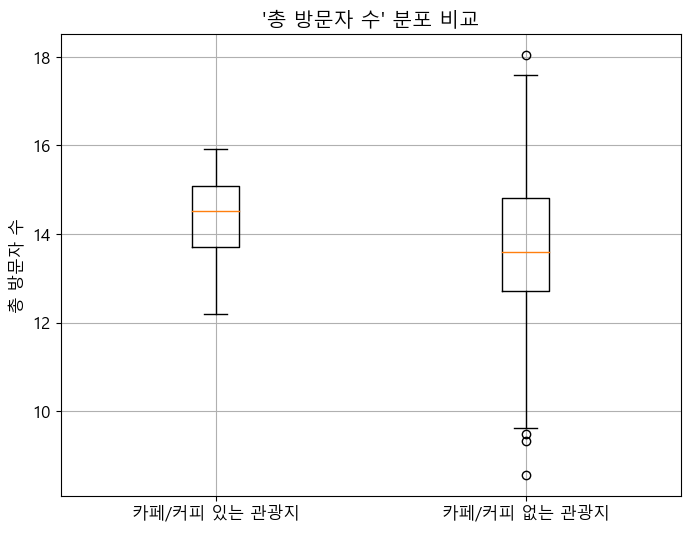

In [158]:
# '총 방문자 수' 로그 변환
has_coffee_df['log_총 방문자 수'] = has_coffee_df['총 방문자 수'].apply(lambda x: 0 if x == 0 else np.log(x + 1))
no_coffee_df['log_총 방문자 수'] = no_coffee_df['총 방문자 수'].apply(lambda x: 0 if x == 0 else np.log(x + 1))

# Box Plot 그리기
plt.figure(figsize=(8, 6))
plt.boxplot([has_coffee_df['log_총 방문자 수'], no_coffee_df['log_총 방문자 수']], labels=['카페/커피 있는 관광지','카페/커피 없는 관광지'])
plt.ylabel('총 방문자 수')
plt.title("'총 방문자 수' 분포 비교")
plt.grid(True)
plt.show()

In [159]:
# t-검정 전에 표본 수 확인
print(f'카페/커피 있는 관광지 개수 : {len(has_coffee_df)}')
print(f'카페/커피 없는 관광지 개수 : {len(no_coffee_df)}')

카페/커피 있는 관광지 개수 : 4
카페/커피 없는 관광지 개수 : 241


In [160]:
# 등분산 검정 (Levene's test)
statistic, p_value = stats.levene(has_coffee_df['총 방문자 수'], no_coffee_df['총 방문자 수'])

if p_value < 0.05:
    print("두 집단은 이분산 가정을 만족한다.")
    t_statistic, p_value = stats.ttest_ind(has_coffee_df['총 방문자 수'], no_coffee_df['총 방문자 수'], equal_var=False)
else:
    print("두 집단은 등분산 가정을 만족한다.")
    t_statistic, p_value = stats.ttest_ind(has_coffee_df['총 방문자 수'], no_coffee_df['총 방문자 수'], equal_var=True)

두 집단은 등분산 가정을 만족한다.


In [161]:
# 독립표본 t-검정 수행
t_statistic, p_value = ttest_ind(has_coffee_df['총 방문자 수'], no_coffee_df['총 방문자 수'])

print("\n독립표본 t-검정 결과:")
print("t-통계량:", t_statistic)
print("p-value:", p_value)


독립표본 t-검정 결과:
t-통계량: 0.027101342050312963
p-value: 0.9784011476552706


In [162]:
# 가설 검정 수행
if p_value < 0.05:
    print("\n'카페/커피 있는 관광지'와 '카페/커피 없는 관광지'의 '총 방문자 수'는 유의미한 차이가 있다.")
else:
    print("\n'카페/커피 있는 관광지'와 '카페/커피 없는 관광지'의 '총 방문자 수'는 유의미한 차이가 없다.")


'카페/커피 있는 관광지'와 '카페/커피 없는 관광지'의 '총 방문자 수'는 유의미한 차이가 없다.


## (11) '숙박시설정보' 가설

### ① 피어슨 상관계수 (Pearson correlation)
- H0 : 관광지의 '숙박시설정보' 유무는 '총 방문자 수'와 상관관계가 없다.
- H1 : 관광지의 '숙박시설정보' 유무는 '총 방문자 수'와 상관관계가 있다.

In [163]:
selected_cols = ['숙박시설정보', '총 방문자 수']
sleep_df = AB_merged_df[selected_cols]

In [164]:
# 상관계수 & p-value 계산
corr_coef, p_value = pearsonr(sleep_df['숙박시설정보'], sleep_df['총 방문자 수'])

print("상관계수:", corr_coef)
print("p-value:", p_value)

상관계수: -0.036955571458897295
p-value: 0.5648283331032926


In [165]:
# 가설 검정 수행
if p_value < 0.05:
    print("귀무가설(H0)을 기각. 관광지의 '숙박시설정보' 유무는 '총 방문자 수'와 상관관계가 있다.")
else:
    print("귀무가설(H0)을 채택. 관광지의 '숙박시설정보' 유무는 '총 방문자 수'와 상관관계가 없다.")

귀무가설(H0)을 채택. 관광지의 '숙박시설정보' 유무는 '총 방문자 수'와 상관관계가 없다.


### ② t-검정 (t-test)
- H0 : '숙박시설정보 있는 관광지'와 '숙박시설정보 없는 관광지'의 평균은 같다. (= 유의미한 차이가 없다.)
- H1 : '숙박시설정보 있는 관광지'와 '숙박시설정보 없는 관광지'의 평균은 다르다. (= 유의미한 차이가 있다.)

In [166]:
has_sleep_df = AB_merged_df[AB_merged_df['숙박시설정보'] == 1]
no_sleep_df = AB_merged_df[AB_merged_df['숙박시설정보'] == 0]

In [167]:
# 각 그룹의 '총 방문자 수' 분포 확인
print("숙박시설정보 있는 관광지:")
print(has_sleep_df['총 방문자 수'].describe())

print("\n숙박시설정보 없는 관광지:")
print(no_sleep_df['총 방문자 수'].describe())

숙박시설정보 있는 관광지:
count    1.030000e+02
mean     2.777185e+06
std      4.306311e+06
min      1.129600e+04
25%      3.755245e+05
50%      8.084050e+05
75%      2.803713e+06
max      2.557998e+07
Name: 총 방문자 수, dtype: float64

숙박시설정보 없는 관광지:
count    1.420000e+02
mean     3.280837e+06
std      8.069513e+06
min      5.230000e+03
25%      3.281535e+05
50%      8.274525e+05
75%      2.587484e+06
max      6.821336e+07
Name: 총 방문자 수, dtype: float64


C:\Users\Yon\AppData\Local\Temp\ipykernel_7912\1241418239.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  has_sleep_df['log_총 방문자 수'] = has_sleep_df['총 방문자 수'].apply(lambda x: 0 if x == 0 else np.log(x + 1))
C:\Users\Yon\AppData\Local\Temp\ipykernel_7912\1241418239.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_sleep_df['log_총 방문자 수'] = no_sleep_df['총 방문자 수'].apply(lambda x: 0 if x == 0 else np.log(x + 1))


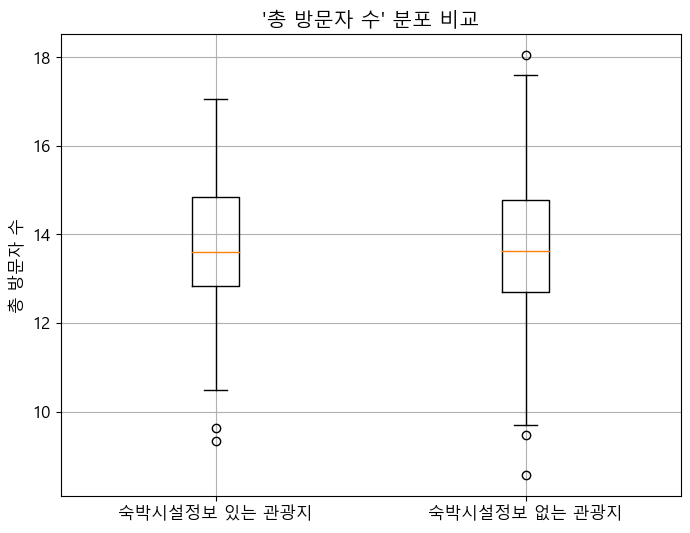

In [168]:
# '총 방문자 수' 로그 변환
has_sleep_df['log_총 방문자 수'] = has_sleep_df['총 방문자 수'].apply(lambda x: 0 if x == 0 else np.log(x + 1))
no_sleep_df['log_총 방문자 수'] = no_sleep_df['총 방문자 수'].apply(lambda x: 0 if x == 0 else np.log(x + 1))

# Box Plot 그리기
plt.figure(figsize=(8, 6))
plt.boxplot([has_sleep_df['log_총 방문자 수'], no_sleep_df['log_총 방문자 수']], labels=['숙박시설정보 있는 관광지','숙박시설정보 없는 관광지'])
plt.ylabel('총 방문자 수')
plt.title("'총 방문자 수' 분포 비교")
plt.grid(True)
plt.show()

In [169]:
# t-검정 전에 표본 수 확인
print(f'숙박시설정보 있는 관광지 개수 : {len(has_sleep_df)}')
print(f'숙박시설정보 없는 관광지 개수 : {len(no_sleep_df)}')

숙박시설정보 있는 관광지 개수 : 103
숙박시설정보 없는 관광지 개수 : 142


In [170]:
# 등분산 검정 (Levene's test)
statistic, p_value = stats.levene(has_sleep_df['총 방문자 수'], no_sleep_df['총 방문자 수'])

if p_value < 0.05:
    print("두 집단은 이분산 가정을 만족한다.")
    t_statistic, p_value = stats.ttest_ind(has_sleep_df['총 방문자 수'], no_sleep_df['총 방문자 수'], equal_var=False)
else:
    print("두 집단은 등분산 가정을 만족한다.")
    t_statistic, p_value = stats.ttest_ind(has_sleep_df['총 방문자 수'], no_sleep_df['총 방문자 수'], equal_var=True)

두 집단은 등분산 가정을 만족한다.


In [171]:
# 독립표본 t-검정 수행
t_statistic, p_value = ttest_ind(has_sleep_df['총 방문자 수'], no_sleep_df['총 방문자 수'])

print("\n독립표본 t-검정 결과:")
print("t-통계량:", t_statistic)
print("p-value:", p_value)


독립표본 t-검정 결과:
t-통계량: -0.5764741304717902
p-value: 0.5648283331030927


In [172]:
# 가설 검정 수행
if p_value < 0.05:
    print("\n'숙박시설정보 있는 관광지'와 '숙박시설정보 없는 관광지'의 '총 방문자 수'는 유의미한 차이가 있다.")
else:
    print("\n'숙박시설정보 있는 관광지'와 '숙박시설정보 없는 관광지'의 '총 방문자 수'는 유의미한 차이가 없다.")


'숙박시설정보 있는 관광지'와 '숙박시설정보 없는 관광지'의 '총 방문자 수'는 유의미한 차이가 없다.


## (12) '운동및오락시설정보' 가설

### ① 피어슨 상관계수 (Pearson correlation)
- H0 : 관광지의 '운동및오락시설정보' 유무는 '총 방문자 수'와 상관관계가 없다.
- H1 : 관광지의 '운동및오락시설정보' 유무는 '총 방문자 수'와 상관관계가 있다.

In [173]:
selected_cols = ['운동및오락시설정보', '총 방문자 수']
entertain_df = AB_merged_df[selected_cols]

In [174]:
# 상관계수 & p-value 계산
corr_coef, p_value = pearsonr(entertain_df['운동및오락시설정보'], entertain_df['총 방문자 수'])

print("상관계수:", corr_coef)
print("p-value:", p_value)

상관계수: 0.038379406953369694
p-value: 0.5499194116193519


In [175]:
# 가설 검정 수행
if p_value < 0.05:
    print("귀무가설(H0)을 기각. 관광지의 '운동및오락시설정보' 유무는 '총 방문자 수'와 상관관계가 있다.")
else:
    print("귀무가설(H0)을 채택. 관광지의 '운동및오락시설정보' 유무는 '총 방문자 수'와 상관관계가 없다.")

귀무가설(H0)을 채택. 관광지의 '운동및오락시설정보' 유무는 '총 방문자 수'와 상관관계가 없다.


### ② t-검정 (t-test)
- H0 : '운동및오락시설정보 있는 관광지'와 '운동및오락시설정보 없는 관광지'의 평균은 같다. (= 유의미한 차이가 없다.)
- H1 : '운동및오락시설정보 있는 관광지'와 '운동및오락시설정보 없는 관광지'의 평균은 다르다. (= 유의미한 차이가 있다.)

In [176]:
has_entertain_df = AB_merged_df[AB_merged_df['운동및오락시설정보'] == 1]
no_entertain_df = AB_merged_df[AB_merged_df['운동및오락시설정보'] == 0]

In [177]:
# 각 그룹의 '총 방문자 수' 분포 확인
print("운동및오락시설정보 있는 관광지:")
print(has_entertain_df['총 방문자 수'].describe())

print("\n운동및오락시설정보 없는 관광지:")
print(no_entertain_df['총 방문자 수'].describe())

운동및오락시설정보 있는 관광지:
count    9.200000e+01
mean     3.402061e+06
std      6.575285e+06
min      1.129600e+04
25%      4.142245e+05
50%      8.256785e+05
75%      3.173520e+06
max      4.388696e+07
Name: 총 방문자 수, dtype: float64

운동및오락시설정보 없는 관광지:
count    1.530000e+02
mean     2.868884e+06
std      6.852537e+06
min      5.230000e+03
25%      3.264390e+05
50%      8.084050e+05
75%      2.482671e+06
max      6.821336e+07
Name: 총 방문자 수, dtype: float64


C:\Users\Yon\AppData\Local\Temp\ipykernel_7912\3372590091.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  has_entertain_df['log_총 방문자 수'] = has_entertain_df['총 방문자 수'].apply(lambda x: 0 if x == 0 else np.log(x + 1))
C:\Users\Yon\AppData\Local\Temp\ipykernel_7912\3372590091.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_entertain_df['log_총 방문자 수'] = no_entertain_df['총 방문자 수'].apply(lambda x: 0 if x == 0 else np.log(x + 1))


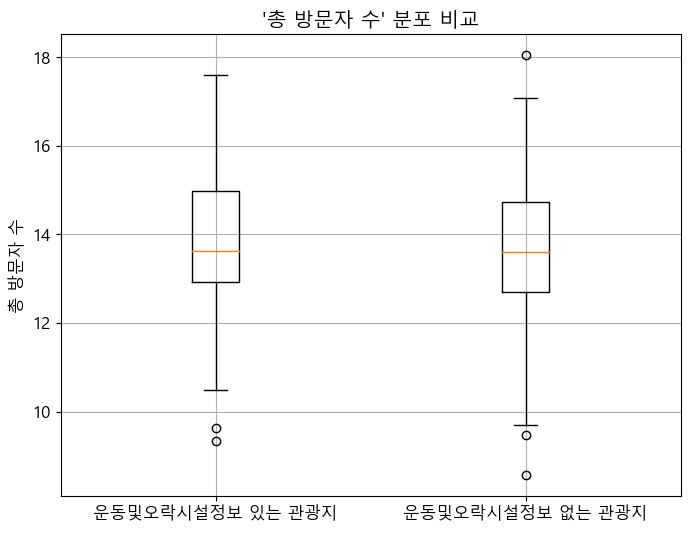

In [179]:
# '총 방문자 수' 로그 변환
has_entertain_df['log_총 방문자 수'] = has_entertain_df['총 방문자 수'].apply(lambda x: 0 if x == 0 else np.log(x + 1))
no_entertain_df['log_총 방문자 수'] = no_entertain_df['총 방문자 수'].apply(lambda x: 0 if x == 0 else np.log(x + 1))

# Box Plot 그리기
plt.figure(figsize=(8, 6))
plt.boxplot([has_entertain_df['log_총 방문자 수'], no_entertain_df['log_총 방문자 수']], labels=['운동및오락시설정보 있는 관광지','운동및오락시설정보 없는 관광지'])
plt.ylabel('총 방문자 수')
plt.title("'총 방문자 수' 분포 비교")
plt.grid(True)
plt.show()

In [180]:
# t-검정 전에 표본 수 확인
print(f'운동및오락시설정보 있는 관광지 개수 : {len(has_entertain_df)}')
print(f'운동및오락시설정보 없는 관광지 개수 : {len(no_entertain_df)}')

운동및오락시설정보 있는 관광지 개수 : 92
운동및오락시설정보 없는 관광지 개수 : 153


In [181]:
# 등분산 검정 (Levene's test)
statistic, p_value = stats.levene(has_entertain_df['총 방문자 수'], no_entertain_df['총 방문자 수'])

if p_value < 0.05:
    print("두 집단은 이분산 가정을 만족한다.")
    t_statistic, p_value = stats.ttest_ind(has_entertain_df['총 방문자 수'], no_entertain_df['총 방문자 수'], equal_var=False)
else:
    print("두 집단은 등분산 가정을 만족한다.")
    t_statistic, p_value = stats.ttest_ind(has_entertain_df['총 방문자 수'], no_entertain_df['총 방문자 수'], equal_var=True)

두 집단은 등분산 가정을 만족한다.


In [182]:
# 독립표본 t-검정 수행
t_statistic, p_value = ttest_ind(has_entertain_df['총 방문자 수'], no_entertain_df['총 방문자 수'])

print("\n독립표본 t-검정 결과:")
print("t-통계량:", t_statistic)
print("p-value:", p_value)


독립표본 t-검정 결과:
t-통계량: 0.5987168564068179
p-value: 0.5499194116191704


In [183]:
# 가설 검정 수행
if p_value < 0.05:
    print("\n'운동및오락시설정보 있는 관광지'와 '운동및오락시설정보 없는 관광지'의 '총 방문자 수'는 유의미한 차이가 있다.")
else:
    print("\n'운동및오락시설정보 있는 관광지'와 '운동및오락시설정보 없는 관광지'의 '총 방문자 수'는 유의미한 차이가 없다.")


'운동및오락시설정보 있는 관광지'와 '운동및오락시설정보 없는 관광지'의 '총 방문자 수'는 유의미한 차이가 없다.


## (13) '휴양및문화시설정보' 가설

### ① 피어슨 상관계수 (Pearson correlation)
- H0 : 관광지의 '휴양및문화시설정보' 유무는 '총 방문자 수'와 상관관계가 없다.
- H1 : 관광지의 '휴양및문화시설정보' 유무는 '총 방문자 수'와 상관관계가 있다.

In [186]:
selected_cols = ['휴양및문화시설정보', '총 방문자 수']
culture_df = AB_merged_df[selected_cols]

In [187]:
# 상관계수 & p-value 계산
corr_coef, p_value = pearsonr(culture_df['휴양및문화시설정보'], culture_df['총 방문자 수'])

print("상관계수:", corr_coef)
print("p-value:", p_value)

상관계수: -0.0005682920742578999
p-value: 0.9929390626196061


In [188]:
# 가설 검정 수행
if p_value < 0.05:
    print("귀무가설(H0)을 기각. 관광지의 '휴양및문화시설정보' 유무는 '총 방문자 수'와 상관관계가 있다.")
else:
    print("귀무가설(H0)을 채택. 관광지의 '휴양및문화시설정보' 유무는 '총 방문자 수'와 상관관계가 없다.")

귀무가설(H0)을 채택. 관광지의 '휴양및문화시설정보' 유무는 '총 방문자 수'와 상관관계가 없다.


### ② t-검정 (t-test)
- H0 : '휴양및문화시설정보 있는 관광지'와 '휴양및문화시설정보 없는 관광지'의 평균은 같다. (= 유의미한 차이가 없다.)
- H1 : '휴양및문화시설정보 있는 관광지'와 '휴양및문화시설정보 없는 관광지'의 평균은 다르다. (= 유의미한 차이가 있다.)

In [189]:
has_culture_df = AB_merged_df[AB_merged_df['휴양및문화시설정보'] == 1]
no_culture_df = AB_merged_df[AB_merged_df['휴양및문화시설정보'] == 0]

In [190]:
# 각 그룹의 '총 방문자 수' 분포 확인
print("휴양및문화시설정보 있는 관광지:")
print(has_culture_df['총 방문자 수'].describe())

print("\n휴양및문화시설정보 없는 관광지:")
print(no_culture_df['총 방문자 수'].describe())

휴양및문화시설정보 있는 관광지:
count    1.220000e+02
mean     3.065259e+06
std      6.259019e+06
min      5.230000e+03
25%      3.532235e+05
50%      7.840910e+05
75%      2.720897e+06
max      4.388696e+07
Name: 총 방문자 수, dtype: float64

휴양및문화시설정보 없는 관광지:
count    1.230000e+02
mean     3.072905e+06
std      7.213346e+06
min      1.310300e+04
25%      3.327440e+05
50%      8.424690e+05
75%      2.685809e+06
max      6.821336e+07
Name: 총 방문자 수, dtype: float64


C:\Users\Yon\AppData\Local\Temp\ipykernel_7912\1546287653.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  has_culture_df['log_총 방문자 수'] = has_culture_df['총 방문자 수'].apply(lambda x: 0 if x == 0 else np.log(x + 1))
C:\Users\Yon\AppData\Local\Temp\ipykernel_7912\1546287653.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_culture_df['log_총 방문자 수'] = no_culture_df['총 방문자 수'].apply(lambda x: 0 if x == 0 else np.log(x + 1))


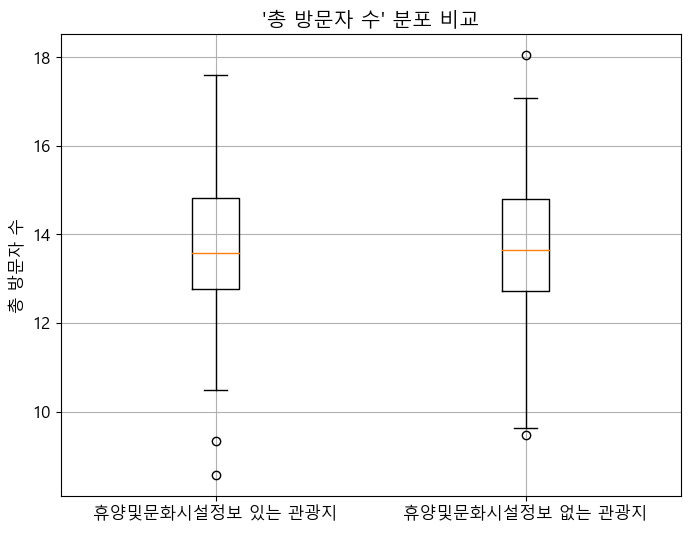

In [191]:
# '총 방문자 수' 로그 변환
has_culture_df['log_총 방문자 수'] = has_culture_df['총 방문자 수'].apply(lambda x: 0 if x == 0 else np.log(x + 1))
no_culture_df['log_총 방문자 수'] = no_culture_df['총 방문자 수'].apply(lambda x: 0 if x == 0 else np.log(x + 1))

# Box Plot 그리기
plt.figure(figsize=(8, 6))
plt.boxplot([has_culture_df['log_총 방문자 수'], no_culture_df['log_총 방문자 수']], labels=['휴양및문화시설정보 있는 관광지','휴양및문화시설정보 없는 관광지'])
plt.ylabel('총 방문자 수')
plt.title("'총 방문자 수' 분포 비교")
plt.grid(True)
plt.show()

In [192]:
# t-검정 전에 표본 수 확인
print(f'휴양및문화시설정보 있는 관광지 개수 : {len(has_culture_df)}')
print(f'휴양및문화시설정보 없는 관광지 개수 : {len(no_culture_df)}')

휴양및문화시설정보 있는 관광지 개수 : 122
휴양및문화시설정보 없는 관광지 개수 : 123


In [193]:
# 등분산 검정 (Levene's test)
statistic, p_value = stats.levene(has_culture_df['총 방문자 수'], no_culture_df['총 방문자 수'])

if p_value < 0.05:
    print("두 집단은 이분산 가정을 만족한다.")
    t_statistic, p_value = stats.ttest_ind(has_culture_df['총 방문자 수'], no_culture_df['총 방문자 수'], equal_var=False)
else:
    print("두 집단은 등분산 가정을 만족한다.")
    t_statistic, p_value = stats.ttest_ind(has_culture_df['총 방문자 수'], no_culture_df['총 방문자 수'], equal_var=True)

두 집단은 등분산 가정을 만족한다.


In [194]:
# 독립표본 t-검정 수행
t_statistic, p_value = ttest_ind(has_culture_df['총 방문자 수'], no_culture_df['총 방문자 수'])

print("\n독립표본 t-검정 결과:")
print("t-통계량:", t_statistic)
print("p-value:", p_value)


독립표본 t-검정 결과:
t-통계량: -0.008858798145880482
p-value: 0.9929390626192552


In [195]:
# 가설 검정 수행
if p_value < 0.05:
    print("\n'휴양및문화시설정보 있는 관광지'와 '휴양및문화시설정보 없는 관광지'의 '총 방문자 수'는 유의미한 차이가 있다.")
else:
    print("\n'휴양및문화시설정보 있는 관광지'와 '휴양및문화시설정보 없는 관광지'의 '총 방문자 수'는 유의미한 차이가 없다.")


'휴양및문화시설정보 있는 관광지'와 '휴양및문화시설정보 없는 관광지'의 '총 방문자 수'는 유의미한 차이가 없다.


## (14) '접객시설정보' 가설

### ① 피어슨 상관계수 (Pearson correlation)
- H0 : 관광지의 '접객시설정보' 유무는 '총 방문자 수'와 상관관계가 없다.
- H1 : 관광지의 '접객시설정보' 유무는 '총 방문자 수'와 상관관계가 있다.

In [196]:
selected_cols = ['접객시설정보', '총 방문자 수']
hospitality_df = AB_merged_df[selected_cols]

In [197]:
# 상관계수 & p-value 계산
corr_coef, p_value = pearsonr(hospitality_df['접객시설정보'], hospitality_df['총 방문자 수'])

print("상관계수:", corr_coef)
print("p-value:", p_value)

상관계수: -0.046534274851759795
p-value: 0.4684247062744904


In [198]:
# 가설 검정 수행
if p_value < 0.05:
    print("귀무가설(H0)을 기각. 관광지의 '접객시설정보' 유무는 '총 방문자 수'와 상관관계가 있다.")
else:
    print("귀무가설(H0)을 채택. 관광지의 '접객시설정보' 유무는 '총 방문자 수'와 상관관계가 없다.")

귀무가설(H0)을 채택. 관광지의 '접객시설정보' 유무는 '총 방문자 수'와 상관관계가 없다.


### ② t-검정 (t-test)
- H0 : '접객시설정보 있는 관광지'와 '접객시설정보 없는 관광지'의 평균은 같다. (= 유의미한 차이가 없다.)
- H1 : '접객시설정보 있는 관광지'와 '접객시설정보 없는 관광지'의 평균은 다르다. (= 유의미한 차이가 있다.)

In [199]:
has_hospitality_df = AB_merged_df[AB_merged_df['접객시설정보'] == 1]
no_hospitality_df = AB_merged_df[AB_merged_df['접객시설정보'] == 0]

In [200]:
# 각 그룹의 '총 방문자 수' 분포 확인
print("접객시설정보 있는 관광지:")
print(has_hospitality_df['총 방문자 수'].describe())

print("\n접객시설정보 없는 관광지:")
print(no_hospitality_df['총 방문자 수'].describe())

접객시설정보 있는 관광지:
count    7.400000e+01
mean     2.593212e+06
std      5.239657e+06
min      1.129600e+04
25%      3.538668e+05
50%      7.475145e+05
75%      2.160562e+06
max      3.653624e+07
Name: 총 방문자 수, dtype: float64

접객시설정보 없는 관광지:
count    1.710000e+02
mean     3.275036e+06
std      7.300287e+06
min      5.230000e+03
25%      3.327440e+05
50%      8.424690e+05
75%      2.750711e+06
max      6.821336e+07
Name: 총 방문자 수, dtype: float64


C:\Users\Yon\AppData\Local\Temp\ipykernel_7912\557292685.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  has_hospitality_df['log_총 방문자 수'] = has_hospitality_df['총 방문자 수'].apply(lambda x: 0 if x == 0 else np.log(x + 1))
C:\Users\Yon\AppData\Local\Temp\ipykernel_7912\557292685.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_hospitality_df['log_총 방문자 수'] = no_hospitality_df['총 방문자 수'].apply(lambda x: 0 if x == 0 else np.log(x + 1))


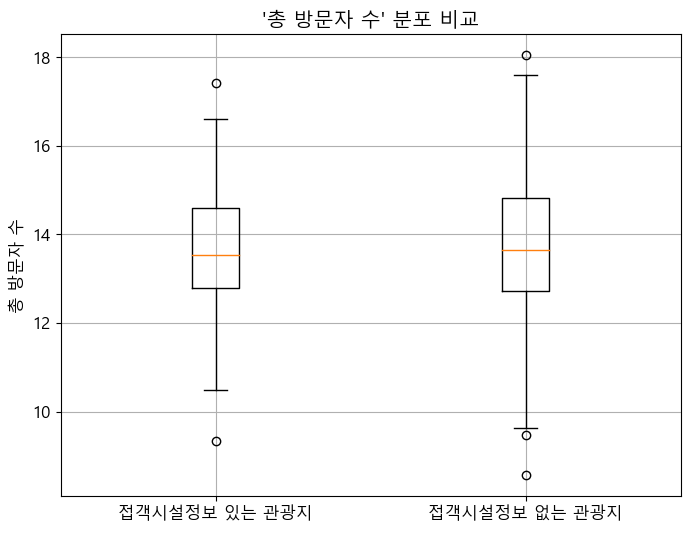

In [201]:
# '총 방문자 수' 로그 변환
has_hospitality_df['log_총 방문자 수'] = has_hospitality_df['총 방문자 수'].apply(lambda x: 0 if x == 0 else np.log(x + 1))
no_hospitality_df['log_총 방문자 수'] = no_hospitality_df['총 방문자 수'].apply(lambda x: 0 if x == 0 else np.log(x + 1))

# Box Plot 그리기
plt.figure(figsize=(8, 6))
plt.boxplot([has_hospitality_df['log_총 방문자 수'], no_hospitality_df['log_총 방문자 수']], labels=['접객시설정보 있는 관광지','접객시설정보 없는 관광지'])
plt.ylabel('총 방문자 수')
plt.title("'총 방문자 수' 분포 비교")
plt.grid(True)
plt.show()

In [202]:
# t-검정 전에 표본 수 확인
print(f'접객시설정보 있는 관광지 개수 : {len(has_hospitality_df)}')
print(f'접객시설정보 없는 관광지 개수 : {len(no_hospitality_df)}')

접객시설정보 있는 관광지 개수 : 74
접객시설정보 없는 관광지 개수 : 171


In [203]:
# 등분산 검정 (Levene's test)
statistic, p_value = stats.levene(has_hospitality_df['총 방문자 수'], no_hospitality_df['총 방문자 수'])

if p_value < 0.05:
    print("두 집단은 이분산 가정을 만족한다.")
    t_statistic, p_value = stats.ttest_ind(has_hospitality_df['총 방문자 수'], no_hospitality_df['총 방문자 수'], equal_var=False)
else:
    print("두 집단은 등분산 가정을 만족한다.")
    t_statistic, p_value = stats.ttest_ind(has_hospitality_df['총 방문자 수'], no_hospitality_df['총 방문자 수'], equal_var=True)

두 집단은 등분산 가정을 만족한다.


In [204]:
# 독립표본 t-검정 수행
t_statistic, p_value = ttest_ind(has_hospitality_df['총 방문자 수'], no_hospitality_df['총 방문자 수'])

print("\n독립표본 t-검정 결과:")
print("t-통계량:", t_statistic)
print("p-value:", p_value)


독립표본 t-검정 결과:
t-통계량: -0.7261842348729832
p-value: 0.4684247062743183


In [205]:
# 가설 검정 수행
if p_value < 0.05:
    print("\n'접객시설정보 있는 관광지'와 '접객시설정보 없는 관광지'의 '총 방문자 수'는 유의미한 차이가 있다.")
else:
    print("\n'접객시설정보 있는 관광지'와 '접객시설정보 없는 관광지'의 '총 방문자 수'는 유의미한 차이가 없다.")


'접객시설정보 있는 관광지'와 '접객시설정보 없는 관광지'의 '총 방문자 수'는 유의미한 차이가 없다.


## (15) '지원시설정보' 가설

### ① 피어슨 상관계수 (Pearson correlation)
- H0 : 관광지의 '지원시설정보' 유무는 '총 방문자 수'와 상관관계가 없다.
- H1 : 관광지의 '지원시설정보' 유무는 '총 방문자 수'와 상관관계가 있다.

In [206]:
selected_cols = ['지원시설정보', '총 방문자 수']
support_df = AB_merged_df[selected_cols]

In [207]:
# 상관계수 & p-value 계산
corr_coef, p_value = pearsonr(support_df['지원시설정보'], support_df['총 방문자 수'])

print("상관계수:", corr_coef)
print("p-value:", p_value)

상관계수: -0.004829481960119758
p-value: 0.9400498565725893


In [208]:
# 가설 검정 수행
if p_value < 0.05:
    print("귀무가설(H0)을 기각. 관광지의 '지원시설정보' 유무는 '총 방문자 수'와 상관관계가 있다.")
else:
    print("귀무가설(H0)을 채택. 관광지의 '지원시설정보' 유무는 '총 방문자 수'와 상관관계가 없다.")

귀무가설(H0)을 채택. 관광지의 '지원시설정보' 유무는 '총 방문자 수'와 상관관계가 없다.


### ② t-검정 (t-test)
- H0 : '지원시설정보 있는 관광지'와 '지원시설정보 없는 관광지'의 평균은 같다. (= 유의미한 차이가 없다.)
- H1 : '지원시설정보 있는 관광지'와 '지원시설정보 없는 관광지'의 평균은 다르다. (= 유의미한 차이가 있다.)

In [209]:
has_support_df = AB_merged_df[AB_merged_df['지원시설정보'] == 1]
no_support_df = AB_merged_df[AB_merged_df['지원시설정보'] == 0]

In [210]:
# 각 그룹의 '총 방문자 수' 분포 확인
print("지원시설정보 있는 관광지:")
print(has_support_df['총 방문자 수'].describe())

print("\n지원시설정보 없는 관광지:")
print(no_support_df['총 방문자 수'].describe())

지원시설정보 있는 관광지:
count    4.000000e+01
mean     2.995545e+06
std      6.056511e+06
min      1.129600e+04
25%      3.644485e+05
50%      7.386815e+05
75%      3.173520e+06
max      3.653624e+07
Name: 총 방문자 수, dtype: float64

지원시설정보 없는 관광지:
count    2.050000e+02
mean     3.083449e+06
std      6.880398e+06
min      5.230000e+03
25%      3.321910e+05
50%      8.320980e+05
75%      2.491014e+06
max      6.821336e+07
Name: 총 방문자 수, dtype: float64


C:\Users\Yon\AppData\Local\Temp\ipykernel_7912\2945234413.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  has_support_df['log_총 방문자 수'] = has_support_df['총 방문자 수'].apply(lambda x: 0 if x == 0 else np.log(x + 1))
C:\Users\Yon\AppData\Local\Temp\ipykernel_7912\2945234413.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_support_df['log_총 방문자 수'] = no_support_df['총 방문자 수'].apply(lambda x: 0 if x == 0 else np.log(x + 1))


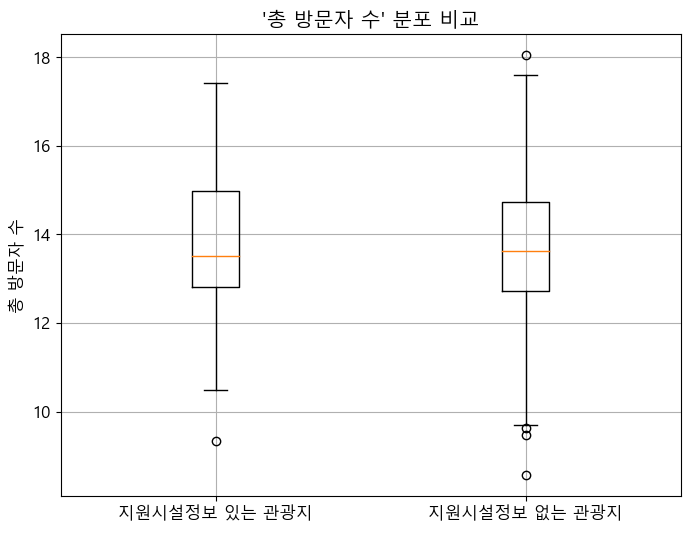

In [211]:
# '총 방문자 수' 로그 변환
has_support_df['log_총 방문자 수'] = has_support_df['총 방문자 수'].apply(lambda x: 0 if x == 0 else np.log(x + 1))
no_support_df['log_총 방문자 수'] = no_support_df['총 방문자 수'].apply(lambda x: 0 if x == 0 else np.log(x + 1))

# Box Plot 그리기
plt.figure(figsize=(8, 6))
plt.boxplot([has_support_df['log_총 방문자 수'], no_support_df['log_총 방문자 수']], labels=['지원시설정보 있는 관광지','지원시설정보 없는 관광지'])
plt.ylabel('총 방문자 수')
plt.title("'총 방문자 수' 분포 비교")
plt.grid(True)
plt.show()

In [212]:
# t-검정 전에 표본 수 확인
print(f'지원시설정보 있는 관광지 개수 : {len(has_support_df)}')
print(f'지원시설정보 없는 관광지 개수 : {len(no_support_df)}')

지원시설정보 있는 관광지 개수 : 40
지원시설정보 없는 관광지 개수 : 205


In [213]:
# 등분산 검정 (Levene's test)
statistic, p_value = stats.levene(has_support_df['총 방문자 수'], no_support_df['총 방문자 수'])

if p_value < 0.05:
    print("두 집단은 이분산 가정을 만족한다.")
    t_statistic, p_value = stats.ttest_ind(has_support_df['총 방문자 수'], no_support_df['총 방문자 수'], equal_var=False)
else:
    print("두 집단은 등분산 가정을 만족한다.")
    t_statistic, p_value = stats.ttest_ind(has_support_df['총 방문자 수'], no_support_df['총 방문자 수'], equal_var=True)

두 집단은 등분산 가정을 만족한다.


In [214]:
# 독립표본 t-검정 수행
t_statistic, p_value = ttest_ind(has_support_df['총 방문자 수'], no_support_df['총 방문자 수'])

print("\n독립표본 t-검정 결과:")
print("t-통계량:", t_statistic)
print("p-value:", p_value)


독립표본 t-검정 결과:
t-통계량: -0.07528505113795371
p-value: 0.9400498565722671


In [215]:
# 가설 검정 수행
if p_value < 0.05:
    print("\n'지원시설정보 있는 관광지'와 '지원시설정보 없는 관광지'의 '총 방문자 수'는 유의미한 차이가 있다.")
else:
    print("\n'지원시설정보 있는 관광지'와 '지원시설정보 없는 관광지'의 '총 방문자 수'는 유의미한 차이가 없다.")


'지원시설정보 있는 관광지'와 '지원시설정보 없는 관광지'의 '총 방문자 수'는 유의미한 차이가 없다.


## ※ 15개 요소들 가설 검정 결과 (요약)

- '화장실’ (표본수 충분/등분산/유의미한 차이 X)
- '주차장’ (표본수 충분/등분산/유의미한 차이 X)
- '관리사무소’ (표본수 충분/등분산/유의미한 차이 X)
- ***'안내소' (표본수 충분/이분산/유의미한 차이 O)***
- '샤워장’ (표본수 부족/등분산/유의미한 차이 X)
- ***'광장' (표본수 부족/이분산/유의미한 차이 O)***
- '수유실' (표본수 부족/등분산/유의미한 차이 X)
- '휴게/쉼터' (표본수 부족/등분산/유의미한 차이 X)
- '공원' (표본수 부족/등분산/유의미한 차이 X)
- '카페/커피' (표본수 부족/등분산/유의미한 차이 X)
#### 
- '숙박시설정보' (표본수 충분/등분산/유의미한 차이 X)
- '운동및오락시설정보' (표본수 충분/등분산/유의미한 차이 X)
- '휴양및문화시설정보' (표본수 충분/등분산/유의미한 차이 X)
- '접객시설정보' (표본수 충분/등분산/유의미한 차이 X)
- '지원시설정보' (표본수 충분/등분산/유의미한 차이 X)

# E. Word Cloud 그리기

In [ ]:
import re
import nltk

from konlpy.tag import Okt
from collections import Counter
from nltk.corpus import stopwords

from wordcloud import WordCloud
from wordcloud import ImageColorGenerator

## ※ '인기관광지'의 '소개글'에는 어떠한 키워드가 많을까? (CA_merged_df 사용)

## (0) C. 인기관광지_외지인 데이터 (한국관광데이터랩)

In [107]:
# "인기관광지_외지인.csv" 불러오기

df1 = pd.read_csv('./인기관광지 데이터/[2207-2306] 강원도_인기관광지/인기관광지_외지인.csv', encoding = 'cp949')
df2 = pd.read_csv('./인기관광지 데이터/[2207-2306] 경기도_인기관광지/인기관광지_외지인.csv', encoding = 'cp949')
df3 = pd.read_csv('./인기관광지 데이터/[2207-2306] 충청남도_인기관광지/인기관광지_외지인.csv', encoding = 'cp949')
df4 = pd.read_csv('./인기관광지 데이터/[2207-2306] 충청북도_인기관광지/인기관광지_외지인.csv', encoding = 'cp949')
df5 = pd.read_csv('./인기관광지 데이터/[2207-2306] 경상남도_인기관광지/인기관광지_외지인.csv', encoding = 'cp949')
df6 = pd.read_csv('./인기관광지 데이터/[2207-2306] 경상북도_인기관광지/인기관광지_외지인.csv', encoding = 'cp949')
df7 = pd.read_csv('./인기관광지 데이터/[2207-2306] 전라남도_인기관광지/인기관광지_외지인.csv', encoding = 'cp949')
df8 = pd.read_csv('./인기관광지 데이터/[2207-2306] 전라북도_인기관광지/인기관광지_외지인.csv', encoding = 'cp949')
df9 = pd.read_csv('./인기관광지 데이터/[2207-2306] 서울특별시_인기관광지/인기관광지_외지인.csv', encoding = 'cp949')
df10 = pd.read_csv('./인기관광지 데이터/[2207-2306] 세종특별자치시_인기관광지/인기관광지_외지인.csv', encoding = 'cp949')
df11 = pd.read_csv('./인기관광지 데이터/[2207-2306] 대전광역시_인기관광지/인기관광지_외지인.csv', encoding = 'cp949')
df12 = pd.read_csv('./인기관광지 데이터/[2207-2306] 대구광역시_인기관광지/인기관광지_외지인.csv', encoding = 'cp949')
df13 = pd.read_csv('./인기관광지 데이터/[2207-2306] 울산광역시_인기관광지/인기관광지_외지인.csv', encoding = 'cp949')
df14 = pd.read_csv('./인기관광지 데이터/[2207-2306] 인천광역시_인기관광지/인기관광지_외지인.csv', encoding = 'cp949')
df15 = pd.read_csv('./인기관광지 데이터/[2207-2306] 광주광역시_인기관광지/인기관광지_외지인.csv', encoding = 'cp949')
df16 = pd.read_csv('./인기관광지 데이터/[2207-2306] 부산광역시_인기관광지/인기관광지_외지인.csv', encoding = 'cp949')
df17 = pd.read_csv('./인기관광지 데이터/[2207-2306] 제주특별자치도_인기관광지/인기관광지_외지인.csv', encoding = 'cp949')

dflist = [df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11, df12, df13, df14, df15, df16, df17]
result_df = pd.concat(dflist)
result_df

,순위,관광지명,주소,분류,외지인 검색 수
0,1,속초관광수산시장,강원 속초시 중앙로147번길 16-0,시장,811824
1,2,쏠비치삼척,강원 삼척시 수로부인길 453-0,콘도미니엄,613581
2,3,소노벨비발디파크,강원 홍천군 한치골길 262-0,콘도미니엄,509816
3,4,소노펠리체 비발디파크,강원 홍천군 한치골길 262-0,콘도미니엄,375248
4,5,체스터톤스속초,강원 속초시 엑스포로 109-0,호텔,360474
...,...,...,...,...,...
95,96,라마다제주시티홀호텔,제주 제주시 중앙로 304-0,호텔,15373
96,97,호텔휘슬락,제주 제주시 서부두2길 26-0,호텔,15208
97,98,롯데마트제주점,제주 제주시 연북로 1-0,대형마트,14990
98,99,보롬왓,제주 서귀포시 번영로 2350-104,기타관광,14789


## (0-0) 데이터 전처리

### (0-1) '시도명' & '시군구명' 컬럼으로 변환

In [108]:
# '주소' 컬럼 기반으로 시도명'과 '시군구명' 컬럼 생성
result_df['시도명'] = result_df['주소'].str.split(' ', n=1).str[0]
result_df['시군구명'] = result_df['주소'].str.split(' ', n=1).str[1].str.split(' ').str[0]

# 기존의 '주소' 컬럼 삭제
result_df.drop(['주소'], axis=1, inplace=True)

# '시도명'과 '시군구명' 컬럼을 가장 앞쪽 열로 위치
result_df.insert(0, '시군구명', result_df.pop('시군구명'))
result_df.insert(0, '시도명', result_df.pop('시도명'))

In [109]:
# '시도명'이 '세종시'인 행의 '시군구명'을 → '세종'으로 변경
result_df.loc[result_df['시도명'] == '세종시', '시군구명'] = '세종'

# result_df[result_df['시도명'].str.contains('세종')]

### (0-2) '시도명' 값 일치시키기

In [110]:
# whole_tour의 '시도명' 값 확인
whole_tour['시도명'].unique()

array(['광주광역시', '서울특별시', '경상북도', '전라남도', '대전광역시', '강원특별자치도', '경기도',
       '부산광역시', '전라북도', '제주특별자치도', '울산광역시', '경상남도', '충청북도', '대구광역시',
       '인천광역시', '충청남도'], dtype=object)

In [111]:
# result_df의 '시도명' 값 확인
result_df['시도명'].unique()

array(['강원', '경기', '충남', '충북', '경남', '경북', '전남', '전북', '서울', '세종시', '대전',
       '대구', '울산', '인천', '광주', '부산', '제주'], dtype=object)

In [112]:
# result_df의 '시도명' 값 변경
result_df['시도명'] = result_df['시도명'].replace({'강원':'강원특별자치도', '경기':'경기도', '경남':'경상남도', '경북':'경상북도', '광주':'광주광역시', '대구':'대구광역시',
                             '대전':'대전광역시', '부산':'부산광역시', '서울':'서울특별시', '세종시':'세종특별자치시', '울산':'울산광역시', '인천':'인천광역시',
                            '전남':'전라남도', '전북':'전라북도', '제주':'제주특별자치도', '충남':'충청남도', '충북':'충청북도'})

result_df['시도명'].unique()

array(['강원특별자치도', '경기도', '충청남도', '충청북도', '경상남도', '경상북도', '전라남도', '전라북도',
       '서울특별시', '세종특별자치시', '대전광역시', '대구광역시', '울산광역시', '인천광역시', '광주광역시',
       '부산광역시', '제주특별자치도'], dtype=object)

### (0-3) '순위' 컬럼 삭제

In [113]:
result_df = result_df.drop('순위', axis=1)

### ※ 최종 확인

In [114]:
result_df  # 1700 rows × 5 columns

,시도명,시군구명,관광지명,분류,외지인 검색 수
0,강원특별자치도,속초시,속초관광수산시장,시장,811824
1,강원특별자치도,삼척시,쏠비치삼척,콘도미니엄,613581
2,강원특별자치도,홍천군,소노벨비발디파크,콘도미니엄,509816
3,강원특별자치도,홍천군,소노펠리체 비발디파크,콘도미니엄,375248
4,강원특별자치도,속초시,체스터톤스속초,호텔,360474
...,...,...,...,...,...
95,제주특별자치도,제주시,라마다제주시티홀호텔,호텔,15373
96,제주특별자치도,제주시,호텔휘슬락,호텔,15208
97,제주특별자치도,제주시,롯데마트제주점,대형마트,14990
98,제주특별자치도,서귀포시,보롬왓,기타관광,14789


## (1) "C.인기관광지_외지인 데이터"에 "A. 전국관광지정보표준데이터"를 병합

### '관광지명', '시도명', '시군구명' 모두 일치하는 행들을 추출하여 병합

In [116]:
CA_merged_df = whole_tour.merge(result_df, on=['관광지명', '시도명', '시군구명'], how = 'inner')

# '외지인 검색 수'로 내림차순
CA_merged_df = CA_merged_df.sort_values(by='외지인 검색 수', ascending=False)

CA_merged_df  # 총 63개 관광지

,시도명,시군구명,관광지명,위도,경도,공공편익시설정보,화장실,주차장,관리사무소,안내소,...,숙박시설정보,운동및오락시설정보,휴양및문화시설정보,접객시설정보,지원시설정보,수용인원수,주차가능수,관광지소개,분류,외지인 검색 수
25,경기도,용인시,에버랜드,37.294067,127.202128,화장실+주차장+관광안내소,1,1,0,1,...,0,0,0,0,0,81546,10400,경기도 용인시 처인구 포곡읍 에버랜드로 199에 위치한 테마파크. 현재까지 대한민국...,테마공원,922619
42,강원특별자치도,홍천군,소노벨비발디파크,37.652337,127.687335,관리사무소+화장실+주차장,1,1,1,0,...,1,1,1,1,1,20000,2000,"휴양과 레저, 골프 및 스키 등 국내 최대규모의 관광휴양단지",콘도미니엄,509816
61,서울특별시,서초구,예술의전당,37.480240,127.014215,오페라글라스+물품보관소+키즈라운지+수유실+주차요금+사전정산기+은행ATM,0,0,0,0,...,0,0,1,0,0,7000,1212,"수준높은 문화예술 콘텐츠와 편리한 시설, 감동적인 서비스가 조화를 이루는 우리나라 ...",공연시설,266127
41,부산광역시,해운대구,해운대해수욕장,35.159107,129.160284,도로+광장+공중화장실 4동+주차장 1개소+관리사무소 1동+변전실 1동,1,1,1,0,...,0,0,1,0,0,800000,203,6월부터 9월까지 해수욕장을 개장하여 해수욕을 즐길 수 있다. 수심이 얕고 조수의 ...,자연경관(하천/해양),220689
27,충청남도,당진시,삽교호관광지,36.888905,126.824754,공중화장실+테마과학관+근린공원,1,0,0,0,...,0,0,0,0,0,500000,728,"서해대교를 비롯, 호수와 바다가 한눈에 들어오는 곳",복합관광시설,212861
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,광주광역시,서구,상무시민공원,35.154228,126.842052,화장실+주차장,1,1,0,0,...,0,1,0,0,0,3000,50,"볼거리가 많고, 온 가족이 운동과 산책을 즐기며 휴식의 기회를 가질 수 있는 공간임",도시공원,10946
9,광주광역시,남구,펭귄마을,35.140076,126.917036,주차장+화장실+관광안내소,1,1,0,1,...,0,0,0,0,0,0,0,"광주광역시천변에 위치한 마을로, 개화기 선교사들의 활동중심지. 펭귄 텃밭은 사람들이...",기타관광,7714
7,광주광역시,북구,원효사,35.148745,126.983272,주차장+화장실+관광안내소,1,1,0,1,...,0,0,0,0,0,200,210,원효대사가 창건한 고찰. 호남지방에서 통일신라시대 작품으로는 가장 아름답고 완전하게...,종교성지,7460
0,광주광역시,서구,무각사,35.153781,126.856018,화장실+주차장,1,1,0,0,...,0,0,0,0,0,100,30,"일주문, 사천왕문, 대웅전, 종각 등 전통사찰의 형태를 여법하게 갖추며 일주문에서 ...",종교성지,6452


## (2) Word Cloud 그리기

In [117]:
# 텍스트 데이터 지정
intro_data = CA_merged_df['관광지소개']

In [118]:
# 빈 줄 및 공백 제거, 특수문자 제거, 형태소 분석, 불용어 처리 및 한 글자 제거
def preprocess_text(text):
    text = text.strip()  # 빈 줄 및 공백 제거
    text = ''.join(char for char in text if char.isalnum() or char.isspace())  # 특수문자 제거
    words = okt.nouns(text)  # 형태소 분석 및 명사 추출
    words = [word for word in words if len(word) > 1]  # 한 글자 제거
    return ' '.join(words)

In [119]:
# '관광지소개' 컬럼의 텍스트 전처리
intro_data_preprocessed = intro_data.apply(preprocess_text)

In [121]:
# '관광지소개' 컬럼의 텍스트 전처리 후 텍스트를 단어로 분할하여 리스트로 만듦
words_list = intro_data_preprocessed.str.split()

# 모든 단어들을 하나의 리스트로 합침
all_words = [word for words in words_list for word in words]

# 각 단어들의 빈도 계산
word_freq = Counter(all_words)

# 빈도 분석 (상위 20개 단어)
print(word_freq.most_common(20))

[('공원', 13), ('문화', 11), ('시설', 10), ('대표', 9), ('한국', 8), ('사찰', 8), ('해수욕장', 7), ('정원', 7), ('조성', 7), ('지정', 7), ('자연', 7), ('최대', 6), ('예술', 6), ('우리나라', 6), ('공간', 6), ('바다', 6), ('폭포', 6), ('관광', 5), ('휴식', 5), ('산책로', 5)]


In [122]:
# 워드 클라우드를 그리기 위해 텍스트를 하나의 문자열로 합침
text_combined = ' '.join(intro_data_preprocessed)

In [123]:
# 폰트 경로 설정
font_path = r'C:/Windows/Fonts/malgun.ttf'

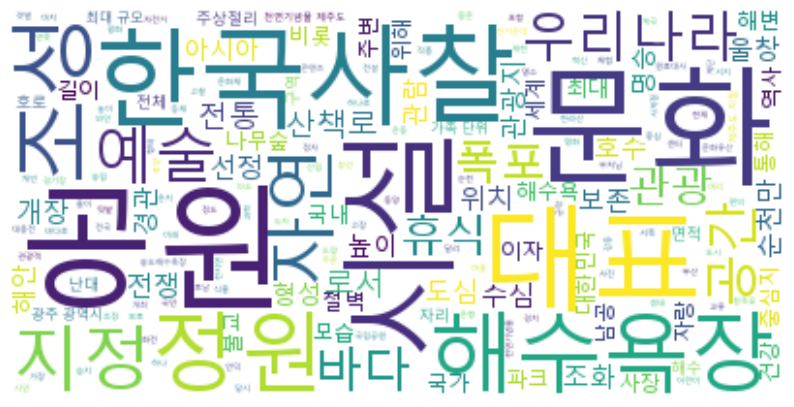

In [124]:
# 워드 클라우드 생성 및 그리기
wordcloud = WordCloud(font_path=font_path, background_color='white').generate(text_combined)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## (c.f.) 관광지의 '소개글'에는 어떠한 키워드가 많을까? (AB_merged_df 사용)

In [100]:
# 텍스트 데이터 지정
intro_data = AB_merged_df['관광지소개']

In [101]:
# 빈 줄 및 공백 제거, 특수문자 제거, 형태소 분석, 불용어 처리 및 한 글자 제거
def preprocess_text(text):
    text = text.strip()  # 빈 줄 및 공백 제거
    text = ''.join(char for char in text if char.isalnum() or char.isspace())  # 특수문자 제거
    words = okt.nouns(text)  # 형태소 분석 및 명사 추출
    words = [word for word in words if len(word) > 1]  # 한 글자 제거
    return ' '.join(words)

In [102]:
# '관광지소개' 컬럼의 텍스트 전처리
intro_data_preprocessed = intro_data.apply(preprocess_text)

In [103]:
# '관광지소개' 컬럼의 텍스트 전처리 후 텍스트를 단어로 분할하여 리스트로 만듦
words_list = intro_data_preprocessed.str.split()

# 모든 단어들을 하나의 리스트로 합침
all_words = [word for words in words_list for word in words]

# 각 단어들의 빈도를 계산
word_freq = Counter(all_words)

# 빈도 분석 (상위 20개 단어)
print(word_freq.most_common(20))

[('문화', 41), ('체험', 41), ('역사', 33), ('마을', 29), ('관광지', 28), ('자연', 26), ('위치', 25), ('시설', 24), ('관광', 22), ('공간', 21), ('공원', 18), ('조성', 17), ('경관', 16), ('예술', 15), ('계곡', 15), ('테마', 14), ('최대', 14), ('전통', 14), ('박물관', 14), ('바다', 14)]


In [104]:
# 워드 클라우드를 그리기 위해 텍스트를 하나의 문자열로 합침
text_combined = ' '.join(intro_data_preprocessed)

In [105]:
# 폰트 경로 설정
font_path = r'C:/Windows/Fonts/malgun.ttf'

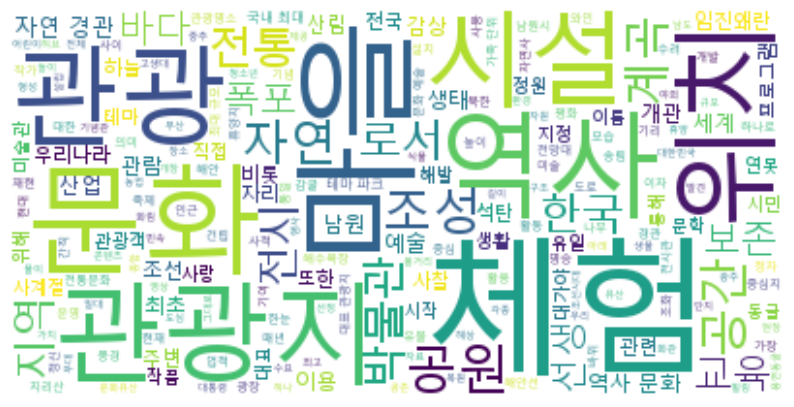

In [106]:
# 워드 클라우드 생성 및 그리기
wordcloud = WordCloud(font_path=font_path, background_color='white').generate(text_combined)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()